<a href="https://colab.research.google.com/github/MicMiao/notebooks/blob/main/%E2%80%9CCOVID_19_Impact_on_Digital_Learning_github_version_ipynb%E2%80%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## COVID-19 Impact on Digital Learning (LearnPlatform dataset 2020)

<img src="https://images.unsplash.com/photo-1597933471507-1ca5765185d8?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=751&q=80" style="width:400px;"/>

This is a notebook for the competition launched on Kaggle (https://www.kaggle.com/c/learnplatform-covid19-impact-on-digital-learning).

We will try to **uncover trends in digital learning** and how such trend relates to factors like district demographics and socio-economic conditions.

In particular, we will try to answer the following questions:

    - What is the picture of digital learning in 2020 for the school districts and the States included in the dataset? 
    - How does students' engagement with online learning platforms relates to different geographic areas? Or to different socio-economic conditions? 
    - How was the students' engagement with different types of technology over the course of the year? 
    - Analysis of competition among similar technology products. Which products performed better than its competitors?



In [ ]:
#@title Datasets from Kaggle can be downloaded using the opendatsets
!pip install opendatasets --upgrade --quiet

import opendatasets as od

While downloading the dataset, you will be asked to provide your Kaggle username and credentails, which you can obtain using the "Create New API Token" button on your account page on Kaggle. Upload the `kaggle.json` notebook using the files tab or enter the username and key manually when prompted.

In [ ]:
#@title Download the datasets
od.download('https://www.kaggle.com/c/learnplatform-covid19-impact-on-digital-learning/data')

In [ ]:
#@title Import the necessary libraries
import os
import pandas as pd
import numpy as np
import math
import glob
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pal = sns.color_palette()
import missingno as msno


## Load engagement data into DataFrame

### Engagement data
> The engagement data are aggregated at school district level, and each file in the folder ```engagement_data``` represents data from **one school district***. 

📝The 4-digit file name represents ```district_id``` which can be used to link to district information in ```district_info.csv```. 

📝The ```lp_id``` can be used to link to product information in ```product_info.csv```.

| Name             | Description                                                                                                    |
|------------------|----------------------------------------------------------------------------------------------------------------|
| time             | date in "YYYY-MM-DD"                                                                                           |
| lp_id            | The unique identifier of the product                                                                           |
| pct_access       | Percentage of students in the district have at least one page-load event of a given product and on a given day |
| engagement_index | Total page-load events per one thousand students of a given product and on a given day                         |
| district_id | The unique identifier of the school district   (Custom added from filenames)                     


**Engagement data** is our main source of information and analysis. Other two files one on school districts and another on products will be merged into engagement data. 

Here we load all the csv files into an unique DataFrame. And using the filename as the column 'district_id', we'll need this column to merge with the 'District Info DataFrame' later on. 

In [ ]:
#@title Load engagement data:
path = '/content/learnplatform-covid19-impact-on-digital-learning/engagement_data'
all_files = glob.glob(path + "/*.csv")

data = [] # pd.concat takes a list of dataframes as an argument
for csv in all_files:
  # read the csv file
  frame = pd.read_csv(csv)
  # split filename and extension
  filename = os.path.splitext(csv)
  # extract district ID from CSV filename tuple
  frame['district_id'] = os.path.basename(filename[0])
  # add new column to new list
  data.append(frame)

engagement_df = pd.concat(data)
engagement_df

,time,lp_id,pct_access,engagement_index,district_id
0,2020-01-01,81236.0,0.04,0.38,3393
1,2020-01-01,28456.0,0.08,10.53,3393
2,2020-01-01,47364.0,1.73,123.31,3393
3,2020-01-01,69863.0,0.19,10.15,3393
4,2020-01-01,72758.0,0.04,0.38,3393
...,...,...,...,...,...
163428,2020-12-31,77698.0,0.00,NaN,7614
163429,2020-12-31,10625.0,0.04,7.02,7614
163430,2020-12-31,18904.0,0.01,0.87,7614
163431,2020-12-31,20050.0,0.01,0.17,7614


For both 'pct_access' and 'engagement_index' we can fill the NaN with zero. As for 'lp_id' we can either delete these 541 rows or fill them also with zero, we choose the later.

In [ ]:
engagement_df.isnull().sum()

In [ ]:
engagement_df.fillna(0, inplace=True)

In [ ]:
# convert district_id from object type to numeric type
engagement_df['district_id'] = pd.to_numeric(engagement_df['district_id'])

## Load districts_info data into DataFrame & some EDA

### District information data

>The district file ```districts_info.csv``` includes information about the **characteristics of school districts**, including data from NCES (2018-19), FCC (Dec 2018), and Edunomics Lab. 

Steps taken to preserve Privacy 🔒 
- Identifiable information about the school districts has been removed. 
- An open source tool ARX (Prasser et al. 2020) was used to transform several data fields and reduce the risks of re-identification. 

📝 For data generalization purposes some data points are released with a range where the actual value falls under. Additionally, there are many missing data marked as 'NaN' indicating that the data was suppressed to maximize anonymization of the dataset.

| Name                   | Description                                                                                                                                                                                                                                                                              |
|------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| district_id            | The unique identifier of the school district                                                                                                                                                                                                                                             |
| state                  | The state where the district resides in                                                                                                                                                                                                                                                  |
| locale                 | NCES locale classification that categorizes U.S. territory into four types of areas: City, Suburban, Town, and Rural. See Locale Boundaries User's Manual for more information.                                                                                                          |
| pct_black/hispanic     | Percentage of students in the districts identified as Black or Hispanic based on 2018-19 NCES data                                                                                                                                                                                       |
| pct_free/reduced       | Percentage of students in the districts eligible for free or reduced-price lunch based on 2018-19 NCES data                                                                                                                                                                              |
| county_connections_ratio | ratio (residential fixed high-speed connections over 200 kbps in at least one direction/households) based on the county level data from FCC From 477 (December 2018 version). See FCC data for more information.                                                                         |
| pp_total_raw             | Per-pupil total expenditure (sum of local and federal expenditure) from Edunomics Lab's National Education Resource Database on Schools (NERD$) project. The expenditure data are school-by-school, and we use the median value to represent the expenditure of a given school district. |
                                                         

In [ ]:
districts_df = pd.read_csv('/content/learnplatform-covid19-impact-on-digital-learning/districts_info.csv')
districts_df 

,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw
0,8815,Illinois,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[14000, 16000["
1,2685,NaN,NaN,NaN,NaN,NaN,NaN
2,4921,Utah,Suburb,"[0, 0.2[","[0.2, 0.4[","[0.18, 1[","[6000, 8000["
3,3188,NaN,NaN,NaN,NaN,NaN,NaN
4,2238,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
228,9515,New York,Rural,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[","[18000, 20000["
229,8103,Tennessee,Rural,"[0.2, 0.4[",NaN,"[0.18, 1[","[8000, 10000["
230,4929,Virginia,Rural,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[","[12000, 14000["
231,7975,California,City,"[0.6, 0.8[","[0.6, 0.8[","[0.18, 1[",NaN


In [ ]:
districts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   district_id               233 non-null    int64 
 1   state                     176 non-null    object
 2   locale                    176 non-null    object
 3   pct_black/hispanic        176 non-null    object
 4   pct_free/reduced          148 non-null    object
 5   county_connections_ratio  162 non-null    object
 6   pp_total_raw              118 non-null    object
dtypes: int64(1), object(6)
memory usage: 12.9+ KB


We have a total of **233** school districts. We have also some missing values, later on we'll fill with a string value 'Not disclosed' if neccessary.

## Exploratory Data Analysis on districts_info:

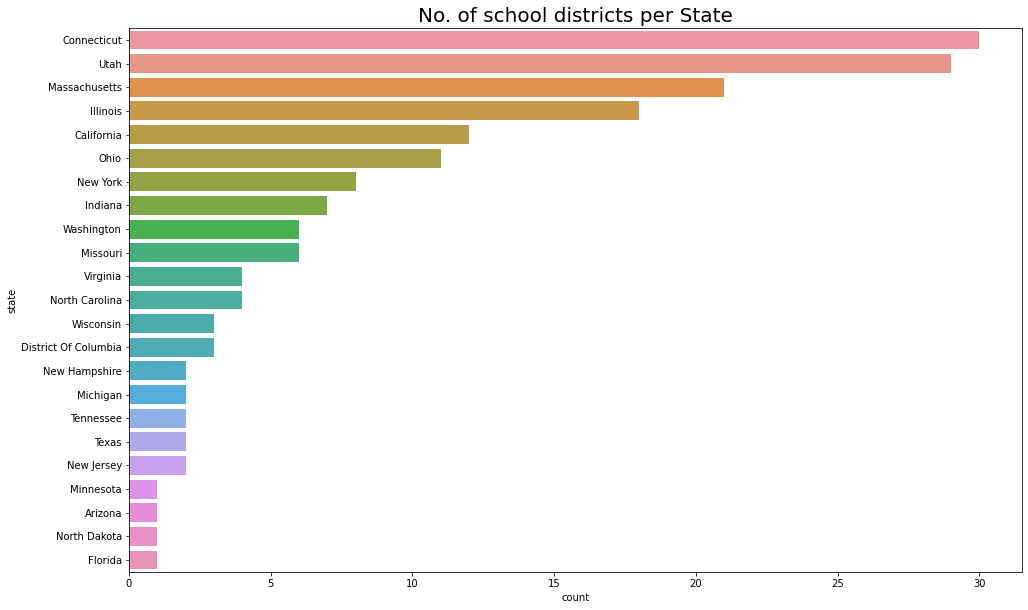

In [ ]:
#@title No. of school districts per State:

plt.figure(figsize=(16,10))
plt.title('No. of school districts per State', size=20)
sns.countplot(y='state', data=districts_df, order=districts_df.state.value_counts(ascending=False).index)
plt.show();

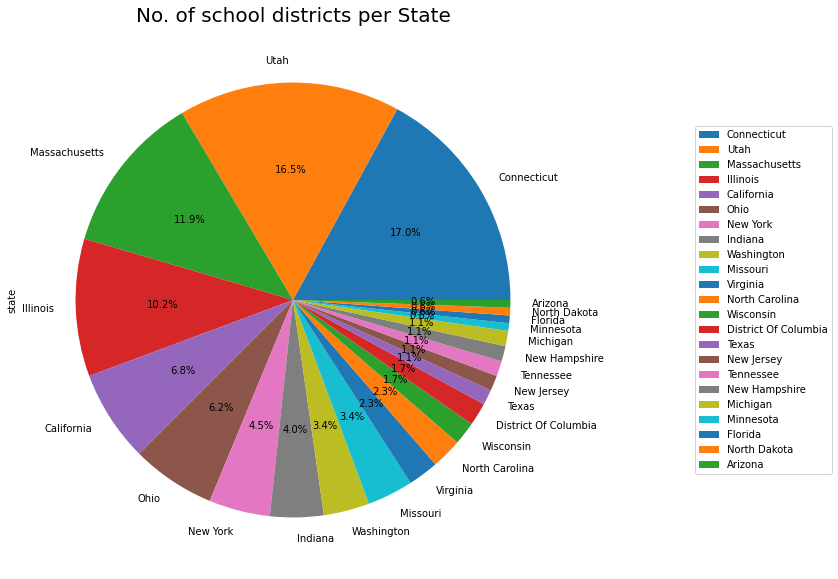

In [ ]:
#@title Percentage of school districts per State:

plt.title('No. of school districts per State', size=20)
districts_df['state'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(16,10), startangle=0).legend(loc='right', bbox_to_anchor=(1.5, 0.5));

We can see that the dataset here is **not uniform**. There are States with a lot of school districts like **Connecticut and Utah** and States that have very small samples like: **Arizona, Florida, North Dakota, Minnesota**. We have to pay attention when we compare the engagement average values for different States, as the number might not be representative especially if the sample size difference is too big.

We have **55.6% of the school districts coming from just 4 States**: Connecticut, Utah, Masschusetts, Illinois.

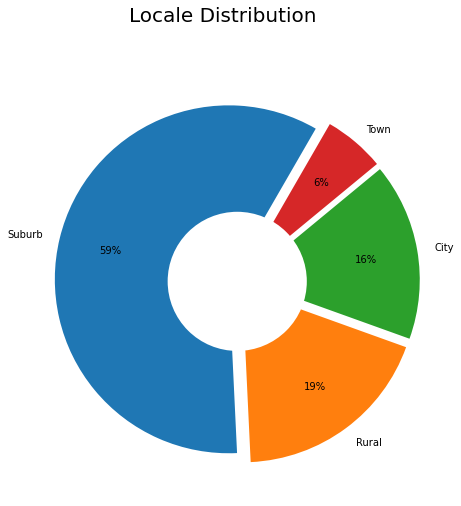

In [ ]:
#@title Locale Distribution Chart:

fig, ax = plt.subplots(figsize=(16, 8))
fig.suptitle('Locale Distribution', size=20)
explode = (0.05, 0.05, 0.05, 0.05)
labels = list(districts_df.locale.value_counts().index)
sizes = districts_df.locale.value_counts().values
ax.pie(sizes, explode=explode, startangle=60, labels=labels, autopct='%1.0f%%', pctdistance=0.7)
ax.add_artist(plt.Circle((0,0), 0.4, fc='white'))
plt.show()


Also for Locale we don't have a uniform or close to uniform distribution. Our data is heavily skewed towards Suburb and Rural.

### Distribution pct_black/hispanic 

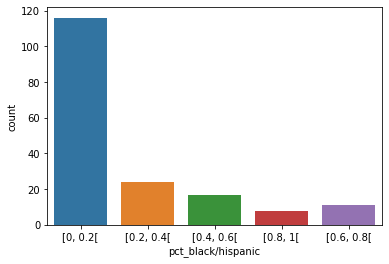

In [ ]:
sns.countplot(data=districts_df, x='pct_black/hispanic')
plt.show()

We have **66% of districts** with the 'pct_black/hispanic' feature (Percentage of students in the districts identified as Black or Hispanic) ranging from 0 to 20%. This might be representative of the whole country or most probably be only representative of the districts selected for our analysis.

We have found an interesting [article](https://www.chalkbeat.org/2020/9/11/21431146/hispanic-and-black-students-more-likely-than-white-students-to-start-the-school-year-online) on the subject of minority groups and distance learning which might provide some additional insights to our analysis. The data summary of which we post below:

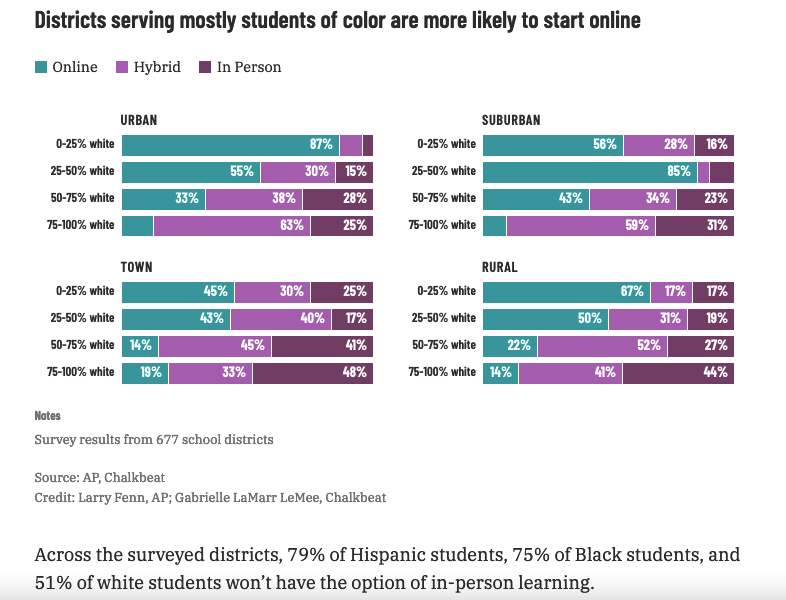

In [ ]:
#@title AP, Chalkbeat Survey Summary:

from IPython.display import Image
Image('/content/learnplatform-covid19-impact-on-digital-learning/Chalkbeat.png')

The survey is conducted by AP and Chalkbeat in 2020 from 677 school districs covering 13 million students. The main takeaway is that **race is a strong predictor of which public schools are offering in-person instruction and which aren't**. 

Back to our analysis: 
If districts with mostly students of color are likely to start online, **we should see a positive correlation** between 'pct_black/hispanic' and engagement metrics assuming more school with online activities correspond to higher digital learning activities. We will try to seek confirmation from our dataset.

### Distribution pct_free/reduced

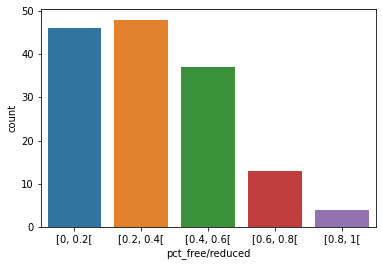

In [ ]:
sns.countplot(data=districts_df, x='pct_free/reduced')
plt.show()

The feature 'pct_free/reduced' gives us an important angle to analyze districts. We will use it as proxy for general economic conditions for a given school district and also for families' income status.

Lastly, after checking county connections ratio data. We discovered that this feature has very little variability and consists of only one value. As it contains no valuable information, we decided to drop it entirely. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



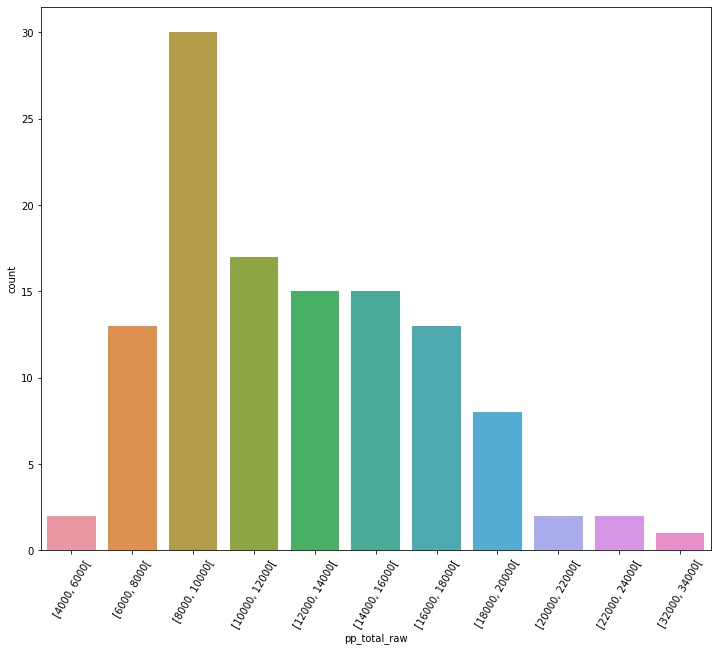

In [ ]:
#@title Per-pupil total expenditure data:

custom_sort = np.array(['[4000, 6000[','[6000, 8000[', '[8000, 10000[', '[10000, 12000[' ,'[12000, 14000[', '[14000, 16000[', '[16000, 18000[', '[18000, 20000[', '[20000, 22000[', '[22000, 24000[', '[32000, 34000['])

plt.figure(figsize=(12,10))
sns.countplot(districts_df.pp_total_raw, order=custom_sort)
plt.xticks(rotation=60);

The majority of spending per pupil is concentrated between 6K to 18K with most of the districts falling into the range **8-10K**.


## Summary from analyzing districts data:
- Majority of the school districs in the dataset coming from only 4 States, therefore we have **an unbalanced dataset**;
- School districts in the dataset mainly are in **suburb** and **rural locales**;
- **66%** of the school districs (~120 over 176) in the dataset have a lower percentage of both Black and Hispanic students 0-20%. Furthermore, based on a survey conducted by Chalkbeat district with lower percentage of students of color are less start school online. Another way to see it is higher percentage of students of color means more likely learning online, which in turn should drive the engagement metrics up. We will try to confirm such finding.

Nevertheless we have to be careful to draw conclusion on whatever insights we might find from this dataset. As it represents only the school districts covered by LearnPlatform's dataset, while the real country/national picture might differ significantly from it.

# Analysis of digitial learning metrics for school districts and States

Now that we have some idea about our dataset. We proceed with our first series of analysis. In particular, here we would like to investigate our `two performance metrics' trend` among all the available school districts: 
- **pct_access**: Percentage of students in the district have at least one page-load event of a given product and on a given day. 
- **engagement_inde**x: Total page-load events per one thousand students of a given product and on a given day.

## Q1: How was the students' engagement during 2020 in each of our districts?

Before we explain in detail how we compute the metrics. It is useful to review how engagement dataframe is organized.

![](https://drive.google.com/uc?export=view&id=1jTIFnWhuS13D-XxSIoU6xIT2NkGHNkL2)

We can see that there are overall more than 22 millions of rows/data points. All the data points are related to the year 2020 from Jan. 1st to Dec. 31st. And the features lp_id and district_id are numbers that identify each technology product (there are over 8600 of them here) and each of the districts (233 districts in total). 

One way to think of interaction betweeen various features is that on any given day we can have multiple rows referring to the same product but different districts or viceversa referring different products and same district. From the picture we can see the first 5 rows are referring to the same day Jan. 1st, the same district no.3393 but 5 different technology products. 

Once we understood the structure of the dataframe then we can start to compute the metrics in the following ways:
- **pct_access**: We will take **the maximum value** for each day and for each district. Why maximum value you may ask. The reason is there are a lot of available products for the students on each day. And if we take the mean, we'll underestimate the overall daily engagement level.

>> E.g. on Jan. 1st 2020, for the school district 1000 we have 138 different products, each with its own pct_access. What was the engagement metric for that district? If we take the mean, which is only 0.145%. But is it correct? We believe if we have 5% of students active on any one of the products, then this 5% should be the reliable estimate for engagement for that day, we don't need to average it out. In this case the max value is 3.6% on a certain product. We don't care which product at this stage, we just know that 3.6% of the students were active on some technology product that day for this district.

- **engagement_index**: for engagement_index we choose the sum, as in this way we can have an idea about the total page-load events per one thousand students for all products on a given day for each of our districts.

In [ ]:
#@title Calculate Max pct_access value for each district:

# For each district and each day, we take the maximum pct_access value registered on all available products:
dist_engage_max_pct_access = engagement_df.groupby(['district_id', 'time']).pct_access.max()


In [ ]:
#@title Calculate Cumulative engagement_index for each district:
# For the engagement_index we choose to sum all the values up to get a total number
dist_engagement_index_sum = engagement_df.groupby(['district_id', 'time']).engagement_index.sum()


In [ ]:
#@title Create an unique DataFrame for both pct_access and engagement_index
dist_pct_access_engagement_df = pd.concat([dist_engage_max_pct_access, dist_engagement_index_sum], axis=1)
dist_pct_access_engagement_df.columns = ['pct_access_max', 'engagement_index_sum']
dist_pct_access_engagement_df

pct_access_max  engagement_index_sum
district_id time                                            
1000        2020-01-01            3.60               3039.34
            2020-01-02           41.76              30226.31
            2020-01-03           49.76              37013.32
            2020-01-04            2.37               1303.03
            2020-01-05            4.76               2448.28
...                                ...                   ...
9927        2020-12-27            2.54               2123.42
            2020-12-28            2.68               2820.85
            2020-12-29            2.66               3075.91
            2020-12-30            2.56               3182.58
            2020-12-31            2.44               3132.87

[79783 rows x 2 columns]

In [ ]:
#@title Remove districts with missing data

# pct_access
# dist_engage_max_pct_access_df = dist_engage_max_pct_access.unstack()
# to_be_removed = list(dist_engage_max_pct_access_df.isnull().sum(axis=1).sort_values(ascending=False).head(18).index)

# engagement_index
dist_engagement_index_sum_df = dist_engagement_index_sum.unstack()
to_be_removed = list(dist_engagement_index_sum_df.isnull().sum(axis=1).sort_values(ascending=False).head(18).index)

# Since they both yield the same list of districts, we can use either one:
for index_num in to_be_removed:
  dist_pct_access_engagement_df.drop(index_num, inplace=True)

We have an substantial number of districts which have a lot of missing data in both pct_access and engagement_index. 

For our analysis, we decide to **drop all districts with more than 100 days of missing data** on pct_access and engagement_index (18 of 233 districts in this case).

In [ ]:
#@title Let's define a general function to plot both pct_access and engagement_index for each district we choose:

def district_metrics(district_num):
  # All the engagement data for the selected district, rolling 7 days to smooth out the effect of weekend:
  district_df = dist_pct_access_engagement_df.loc[[str(district_num)]].rolling(7, min_periods=1).mean()

  # Create a series of dates for x values:
  dates = pd.date_range("1 1 2020", periods=366, freq="D")

  # Create chart:
  fig, axs = plt.subplots(2, 1, figsize=(16,16), sharex=True)

  # Ploting pct_access:
  axs[0].set_title('School district no. ' + str(district_num) + ' daily pct_access maximum values during 2020', size=16)
  axs[0].plot(dates, district_df['pct_access_max'])

  # Ploting engagement_index:
  axs[1].set_title('School district no. ' + str(district_num) + ' daily engagement_index sum values during 2020', size=16)
  axs[1].plot(dates, district_df['engagement_index_sum'])
  plt.show();

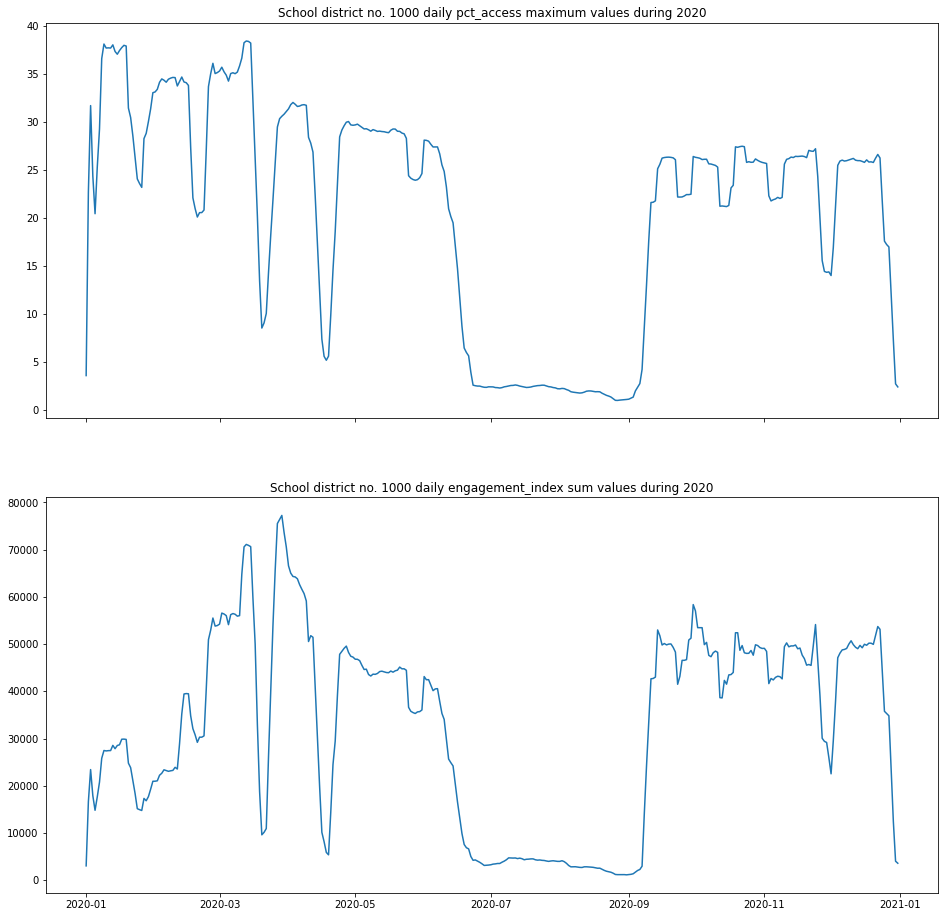

In [ ]:
#@title Insert the district number to get its engagement metrics:

district_number =  1000#@param {type:"number"}

district_metrics(district_number)

We can see for the school district no.1000 the maximum percentage of students using a digital learning product oscillates between **25-40%** on the most active days aka **max pct_access**. We can see the drop during summer vacation time, and subsequent rise in September when school year restarts.

While the total page-load events per one thousand students for all digital learning products oscillates wildly during the first part of the year (almost **80k page-load events at peak and less than 10k page-load events at bottom**) and remained more stable in the second half. This could be due to the outbreak of pandemic in the first half of 2020 with schools being closed in march. Further school district level investigation can tell us more about these oscillations.

While it is useful to have a picture on each district, it would be more interesting if we can compare them. So we will be able to answer questions like:

- Which are the top 10 districts for both pct_access and engagement_index?
- And which are the bottom 10?
- How big is the engagement difference between top 10 and bottom 10?
- If we choose two or more districts of our interest. How big is their engagement difference? And what are the underlying causes?  

In [ ]:
#@title Define a function for pct_access metric:

def districts_pa(*args):  # pass a number of districts you want
  
  # Create an empty df:
  tot_df = dist_pct_access_engagement_df[dist_pct_access_engagement_df.index.get_level_values('district_id') == '1000']['pct_access_max'].rolling(7, min_periods=1).mean()
  tot_df = tot_df.to_frame()
  tot_df = tot_df.droplevel('district_id', axis=0)
  tot_df.drop(['pct_access_max'], axis=1, inplace=True)

  for dist in args:
    # Extract pct_access_max from the original dataframe:
    pa_df = dist_pct_access_engagement_df[dist_pct_access_engagement_df.index.get_level_values('district_id') == str(dist)]['pct_access_max'].rolling(7, min_periods=1).mean()
    pa_df = pa_df.to_frame()
    pa_df = pa_df.droplevel('district_id', axis=0)
    pa_df.rename(columns={"pct_access_max": "pa"+str(dist)}, inplace=True)

    # Concat to the tot_df
    tot_df = pd.concat([tot_df, pa_df], axis=1)

  # Outside the for loop:
  tot_df.index = pd.to_datetime(tot_df.index)

  # Plot the chart:
  fig, ax = plt.subplots(figsize=(16,8))
  sns.lineplot(data=tot_df, palette='tab10', linewidth=2.5)
  ax.set_title("max pct_access trend for selected districts", size=16)
  ax.set_ylabel('max pct_access')


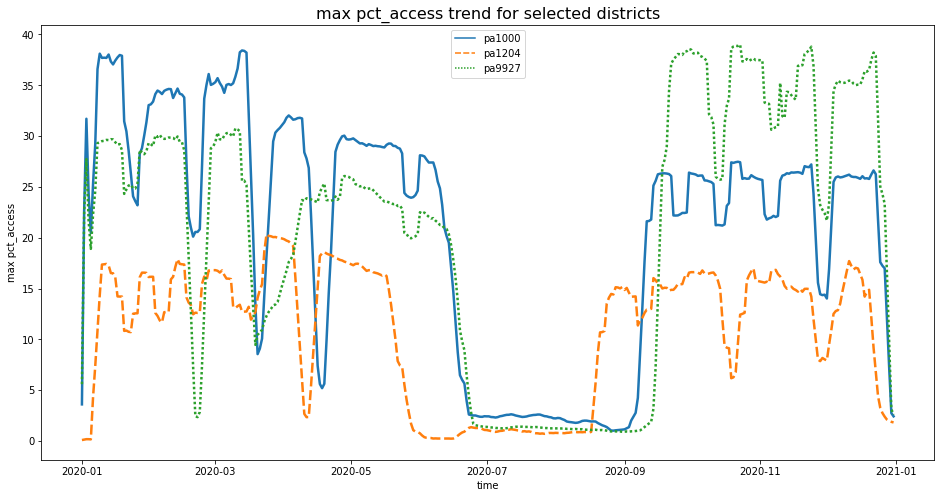

In [ ]:
# pct_access for the districts we've chosen:
districts_pa(1000, 1204, 9927)

With a basic chart we can already ask some very interesting questions on pct_access here:

- Percentage of students in the district no.1000 that have at least one page-load event of a given product and on a given day are higher than district no. 9927 during the first half of 2020. However after the summer break, the second outperforms the first. What happened in the second part of the year? What's the cause of this overtaking? 
- What is the reason of the underperformance of school district no. 1204? Its pct_access values are less than half of other two.

On a district level, this type of inquiry can be very interesting. We just need to select districts of our interest, make the comparison and further investigate on any substantial difference.

In [ ]:
#@title Define a function for engagement_index metric:

def districts_ei(*args):  # pass a number of districts you want
  
  # Create an empty df:
  tot_df = dist_pct_access_engagement_df[dist_pct_access_engagement_df.index.get_level_values('district_id') == '1000']['engagement_index_sum'].rolling(7, min_periods=1).mean()
  tot_df = tot_df.to_frame()
  tot_df = tot_df.droplevel('district_id', axis=0)
  tot_df.drop(['engagement_index_sum'], axis=1, inplace=True)

  for dist in args:
    # Extract engagement_index from the original dataframe:
    ie_df = dist_pct_access_engagement_df[dist_pct_access_engagement_df.index.get_level_values('district_id') == str(dist)]['engagement_index_sum'].rolling(7, min_periods=1).mean()
    ie_df = ie_df.to_frame()
    ie_df = ie_df.droplevel('district_id', axis=0)
    ie_df.rename(columns={"engagement_index_sum": "ie"+str(dist)}, inplace=True)

    # Concat to the tot_df
    tot_df = pd.concat([tot_df, ie_df], axis=1)

  # Outside the for loop, convert index to datetime:
  tot_df.index = pd.to_datetime(tot_df.index)

  # Plot the chart:
  fig, ax = plt.subplots(figsize=(16,8))
  sns.lineplot(data=tot_df, palette='tab10', linewidth=2.5)
  ax.set_title("sum engagement index trend for selected districts", size=16)
  ax.set_ylabel('sum engagement_index')


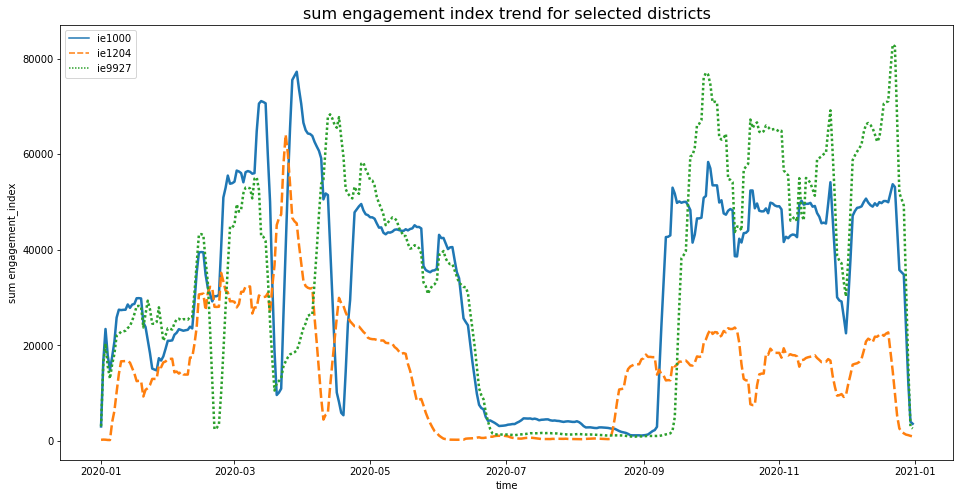

In [ ]:
# engagement_index for the districts we've chosen:
districts_ei(1000, 1204, 9927)

As for engagement_index: we've choose the same three districts as before, and we can see some similaries compared to pct_access:
- District no.1000 outperforms in the first part of the year, while district no. 9927 overtakes as year progresses (here it overtakes in April!);
- District no.1204 generally underperforms over the year, especially in the second half. 
- The wild spikes in March and Aprile are mostly due to the havoc caused by the pandemic as we know a lot of schools have been closed during that period.

## Q2: Which are the top 10 districts?

We have 215 school districts in total (233 minus the 18 that we have removed due to too much missing data). Let's find out which are the best performers.

We use the **annual mean** for both pct_access and engagement_index to decide which are the top performers and which are the bottom ones.

In [ ]:
#@title Create a new dataframe with annual mean values of the metrics for all districts:

# Create a new empty DataFrame with index districts of dist_pct_access_engagement_df:
df_index = dist_pct_access_engagement_df.index.get_level_values(level=0).drop_duplicates()
dist_pct_engagement_mean_df = pd.DataFrame(index=df_index)

# Store all the annual mean metrics into two lists:
dist_pct_mean = []
dist_engagement_index_mean = []

for district, sub_df in dist_pct_access_engagement_df.groupby(level=0):
  dist_pct_mean.append(sub_df['pct_access_max'].mean())
  dist_engagement_index_mean.append(sub_df['engagement_index_sum'].mean())

# Append two lists to the new df:
dist_pct_engagement_mean_df['pct_access_mean'] = dist_pct_mean
dist_pct_engagement_mean_df['engagement_index_mean'] = dist_engagement_index_mean
dist_pct_engagement_mean_df

,pct_access_mean,engagement_index_mean
district_id,,
1000,20.634672,32360.946913
1039,15.085328,23953.756721
1044,30.956530,50708.394891
1052,27.835601,52684.947322
1131,6.576571,5323.003143
...,...,...
9778,12.436421,16300.882951
9812,17.092978,31415.260164
9839,16.975601,23386.144945


In [ ]:
#@title Top 10 pct_access districts:
top10_pa = dist_pct_engagement_mean_df.pct_access_mean.sort_values(ascending=False).head(10).to_frame()
top10_pa

,pct_access_mean
district_id,
5890,39.596776
9553,38.836366
2779,37.625601
8815,37.183718
3228,36.620246
9536,36.340305
6577,35.900246
6194,35.862814
2598,35.669044


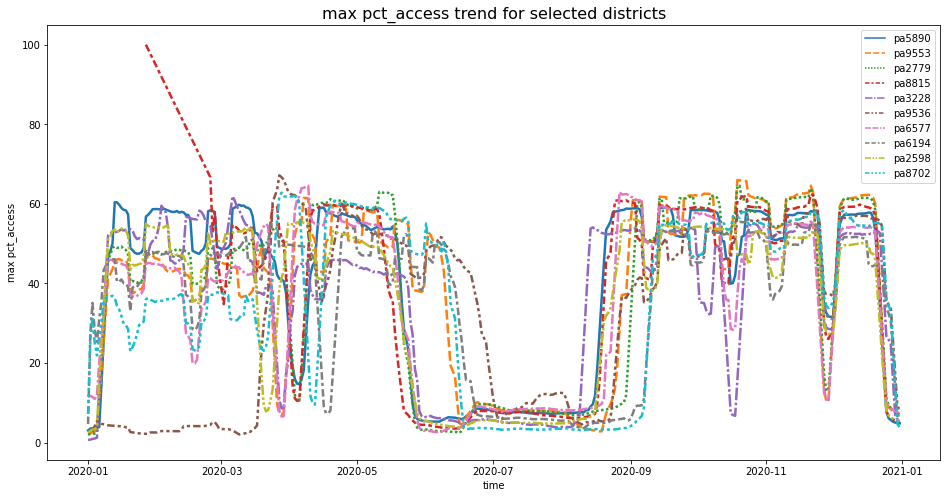

In [ ]:
# pct_access for top10 districts:
districts_pa(5890, 9553, 2779, 8815, 3228, 9536, 6577, 6194, 2598, 8702)

We noticed 2 suspicious data values:
- District no.8815's first three months data may contain some error, as it reaches 100% as pct_access (which is suspiciously high);
- District no.9536 inversely has very low data values for the first three months. It can also be another data acquisition problem.

We need to check these values with our client/colleagues who handle the data acquisition process.


With exception of these two segments of data, the overal picture is quite clear:
- Top 10 district for the **pct_access metric** have an average of **50-60%** value during the school calendar peak months and an **overall average annual value in the range of 35-40%**.


In [ ]:
#@title Let's link the top 10 districts with some other information to have a more complete picture:
top10_pa.index = top10_pa.index.astype(int)
districts_df.district_id = districts_df.district_id.astype(int)

top10_pa.merge(districts_df, how='left', left_index=True, right_on='district_id').set_index('district_id')

,pct_access_mean,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw
district_id,,,,,,,
5890,39.596776,Illinois,Suburb,"[0.2, 0.4[","[0.2, 0.4[","[0.18, 1[","[18000, 20000["
9553,38.836366,Illinois,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[14000, 16000["
2779,37.625601,Illinois,Rural,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[10000, 12000["
8815,37.183718,Illinois,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[14000, 16000["
3228,36.620246,Indiana,Town,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[","[8000, 10000["
9536,36.340305,New York,City,"[0.8, 1[","[0.8, 1[","[0.18, 1[",NaN
6577,35.900246,Illinois,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[10000, 12000["
6194,35.862814,Connecticut,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[",NaN
2598,35.669044,Ohio,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[",NaN


Here we have linked the dataframe with districts information. And some new findings emerged:
- Top 4 are all from the **State of Illinois**, and half of the top10 are from the same State. Even though we don't have a balanced dataset at national level and Illinois is among the top 4 States in terms of school districts in our database (*see above the chart of No. of school districts per State)*. However Utah and Massachusetts have no presence in this ranking and Connecticut has only one at the position no.7. The outperformance of Illinois' districts is an interesting point to be further studied.
- Eight of the ten districts have very **low percentage of minority students and students eligible for free/reduced-price lunch**. This might indicate a correlation between high level income at district level with high adoption of digital learning tools in the same area.
- **The district no.9536** from New York has very high percentage of black/hispanic students and eligible for free/reduced-price lunch students, both between 80-100%. This is a very encouraging news, as we might infer that harsh economic conditions doesn't have to be an obstacle to digital learning. If this is true, maybe other districts from poor areas can adopt some of the best practice of this district to increase their students' engagement with digital learning products.

Let's do the same list for engagement_index, maybe we can come up with some other findings.

In [ ]:
#@title Top 10 engagement index districts:
pd.options.display.float_format = "{:,.2f}".format

top10_ei = dist_pct_engagement_mean_df.engagement_index_mean.sort_values(ascending=False).head(10).to_frame()
top10_ei

,engagement_index_mean
district_id,
8815,"100,276.01"
9536,"95,770.59"
2779,"88,344.66"
9553,"83,851.61"
6194,"76,675.84"
5890,"76,169.93"
6512,"74,277.08"
3314,"74,033.02"
9463,"71,684.57"


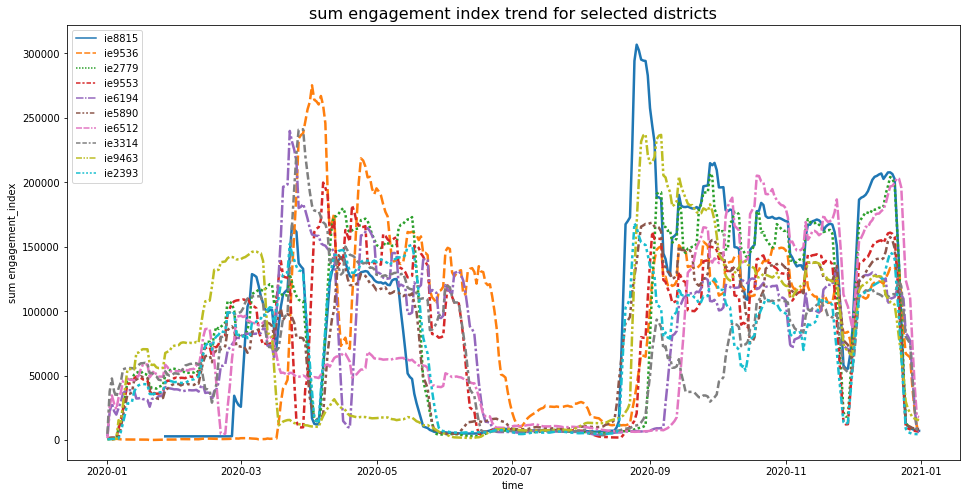

In [ ]:
# Engagement_index for top10 districts:
districts_ei(8815, 9536, 2779, 9553, 6194, 5890, 6512, 3314, 9463, 2393)

For our top 10 districts on engagement index:
- The overall annual average total page-load events per one thousand students ranges from **71,000 to 100,000 events**.
- During peak months the metric stays **in the range 100,000 and 200,000** with highest peak touching 300,000 events.
- The trend oscillates a lot during the first half, while remained more stable during the second half of the year. We can think of school disruption and closure during pandemic outbreak in the first 3 months of 2020. As students, teachers and parents get progressively more prepared during the year, the usage of digital learning tools becomes more stable in the second half of the 2020.


In [ ]:
#@title Let's link the top 10 districts with some other information to have a more complete picture:
top10_ei.index = top10_ei.index.astype(int)

top10_ei.merge(districts_df, how='left', left_index=True, right_on='district_id').set_index('district_id')

,engagement_index_mean,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw
district_id,,,,,,,
8815,"100,276.01",Illinois,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[14000, 16000["
9536,"95,770.59",New York,City,"[0.8, 1[","[0.8, 1[","[0.18, 1[",NaN
2779,"88,344.66",Illinois,Rural,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[10000, 12000["
9553,"83,851.61",Illinois,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[14000, 16000["
6194,"76,675.84",Connecticut,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[",NaN
5890,"76,169.93",Illinois,Suburb,"[0.2, 0.4[","[0.2, 0.4[","[0.18, 1[","[18000, 20000["
6512,"74,277.08",Massachusetts,Suburb,"[0, 0.2[",NaN,"[0.18, 1[","[14000, 16000["
3314,"74,033.02",Connecticut,Rural,"[0, 0.2[","[0, 0.2[","[0.18, 1[",NaN
9463,"71,684.57",NaN,NaN,NaN,NaN,NaN,NaN


It looks like a big portion of top 10 are the same districts for both pct_access and engagement_index, as it may be expected.

In [ ]:
#@title Top performers on both metrics:

list1 = top10_pa.index.values.tolist()
list2 = top10_ei.index.values.tolist()
set1 = set(list1)
intersection = list(set1.intersection(list2))
intersection


dist_pct_engagement_mean_df.index = dist_pct_engagement_mean_df.index.astype(int)
top10_combined = dist_pct_engagement_mean_df.loc[intersection]

top10_combined.index = top10_combined.index.astype(int)
top10_combined.merge(districts_df, how='left', left_index=True, right_on='district_id').set_index('district_id').sort_values(['pct_access_mean', 'engagement_index_mean'], ascending=[False, False])


,pct_access_mean,engagement_index_mean,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw
district_id,,,,,,,,
5890,39.60,"76,169.93",Illinois,Suburb,"[0.2, 0.4[","[0.2, 0.4[","[0.18, 1[","[18000, 20000["
9553,38.84,"83,851.61",Illinois,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[14000, 16000["
2779,37.63,"88,344.66",Illinois,Rural,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[10000, 12000["
8815,37.18,"100,276.01",Illinois,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[14000, 16000["
9536,36.34,"95,770.59",New York,City,"[0.8, 1[","[0.8, 1[","[0.18, 1[",NaN
6194,35.86,"76,675.84",Connecticut,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[",NaN


Now that we have completed our top10 analysis on both metrics, we can see that it confirms our previous observations:
- **The State of Illinois** occupies half of the top10 ranking, its districts have very high performance/engagement with digital learning technologies. However we have to keep in mind that both Illinois and Connecticut are two of the four States where the bulk of the data (over 55%) is coming from. So we have to be careful here, maybe other States' districts will have higher engagement metrics if we add more data into the analysis. Same reasoning work for the locale, since we have ~60% of the data coming from Suburb, we can't make any hasty conclusion here.
- In NY City we have district no.9536 with its perculiar characteristics of high percentage of minority ethnicities students and high percentage of students eligible for free and reduced-price lunch. And yet it is among the top 6 in the combined ranking. This is a very encouraging news, as we might that **harsh economic conditions don't have to be an obstacle to digital learning**.
-  With regard to the survery conducted by AP and Chalkbeat with the finding that high percentage of students of color means high chance of online learning. However our analysis doesn't confirm this. We see instead **a lower percentage of pct_black/hispanic together with a lower pct_free/reduced values correpond to higher engagement metrics**. Later on we will try to confirm this also with a correlation matrix.

## Having analyzed the top 10, now let's have a look at the bottom 10:
## Q3: Which are the bottom 10 districts?

In [ ]:
#@title Bottom 10 pct_access districts:
bottom10_pa = dist_pct_engagement_mean_df.pct_access_mean.sort_values(ascending=True).head(10).to_frame()
bottom10_pa

,pct_access_mean
district_id,
5042,2.88
4683,2.90
3471,2.94
4373,3.49
7767,3.84
2870,4.45
3558,4.72
8017,4.87
2106,5.00


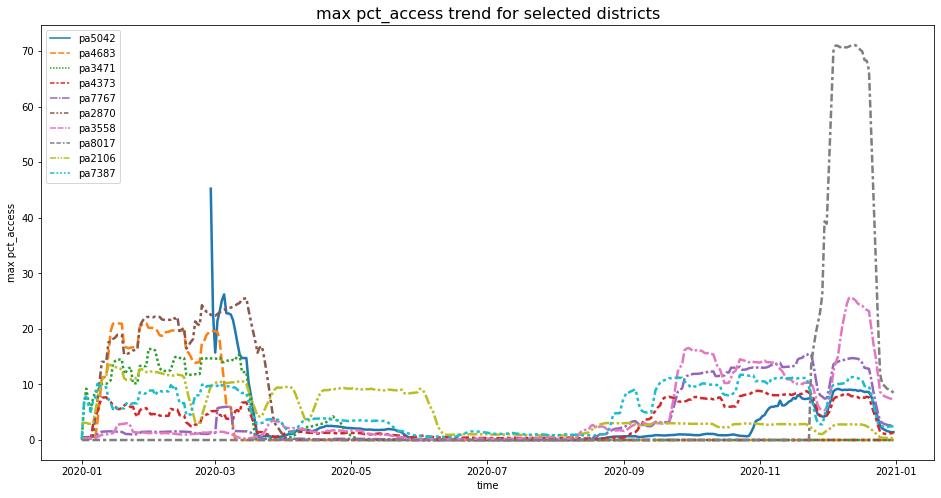

In [ ]:
b10pa = list(bottom10_pa.index)
districts_pa(*b10pa)

There are two notable examples that can be indicative of data acquisition problem:
- District no.5042 around march 2020.
- District no.8017 which have zero pct_access until december, then the data explodes.

We have to check with client/colleagues about these examples and make sure that they are correct. 

Despite the above two data examples, the overall picture is still valid. Here for our bottom10, the pct_access metric have **an average of 10-20% value during the school calendar peak months** (vs. 50-60% of the top10) and **an overall average annual value in the range of 3-6%** (vs. 35-40% of the top10).

We can see that for pct_access, **top10 are 2.5-6X on peak values** and **6-13X on annual average values** compared to the bottom10.

In [ ]:
#@title Bottom 10 engagement_index districts:
bottom10_ei = dist_pct_engagement_mean_df.engagement_index_mean.sort_values(ascending=True).head(10).to_frame()
bottom10_ei

,engagement_index_mean
district_id,
3471,"1,581.42"
5042,"2,722.39"
4683,"3,613.39"
4373,"4,411.79"
2870,"5,258.62"
1131,"5,323.00"
7767,"6,379.52"
7308,"6,663.86"
2567,"6,822.32"


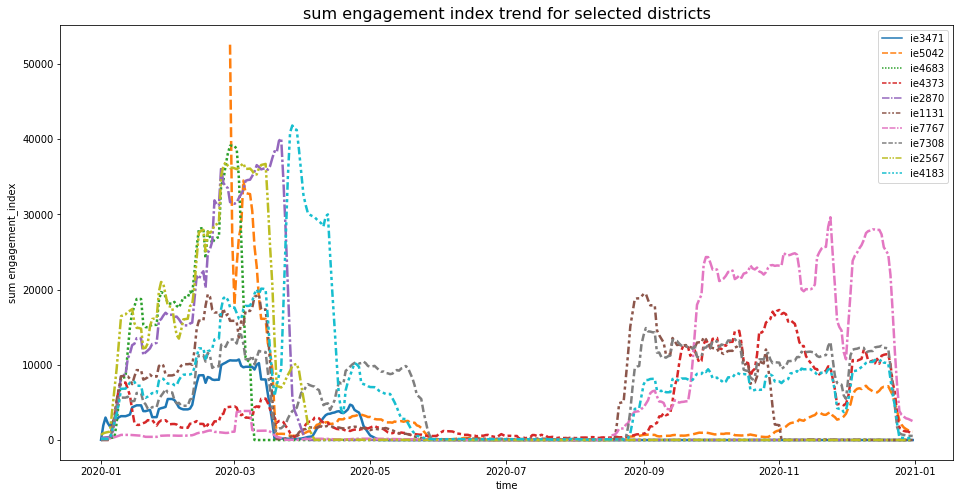

In [ ]:
b10ei = list(bottom10_ei.index)
districts_ei(*b10ei)

For our bottom 10 districts on engagement index:

- During peak months the metric stays in the **range from 10,000 to 40,000** (vs. 100,000 to 200,000 events of the top10).
- The overall annual average total page-load events per one thousand students ranges **from 1,500 to 7,500 events** (vs. 71,000 to 100,000 events of the top10).


We are seeing that for engagement_index, **top10 are 2.5-20X on peak values** and **9.5-67X on annual average values** compared to the bottom10.

In [ ]:
#@title Bottom performers on both metrics:

list1 = bottom10_pa.index.values.tolist()
list2 = bottom10_ei.index.values.tolist()
set1 = set(list1)
intersection = list(set1.intersection(list2))
intersection


dist_pct_engagement_mean_df.index = dist_pct_engagement_mean_df.index.astype(int)
bottom10_combined = dist_pct_engagement_mean_df.loc[intersection]

bottom10_combined.index = bottom10_combined.index.astype(int)
bottom10_combined.merge(districts_df, how='left', left_index=True, right_on='district_id').set_index('district_id').sort_values(['pct_access_mean', 'engagement_index_mean'], ascending=[True, True])

,pct_access_mean,engagement_index_mean,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw
district_id,,,,,,,,
5042,2.88,"2,722.39",Illinois,Town,"[0.2, 0.4[","[0.8, 1[","[0.18, 1[","[10000, 12000["
4683,2.90,"3,613.39",Texas,Suburb,"[0.4, 0.6[","[0.4, 0.6[","[0.18, 1[","[8000, 10000["
3471,2.94,"1,581.42",NaN,NaN,NaN,NaN,NaN,NaN
4373,3.49,"4,411.79",Utah,City,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[8000, 10000["
7767,3.84,"6,379.52",North Carolina,City,"[0.4, 0.6[","[0.6, 0.8[","[0.18, 1[","[10000, 12000["
2870,4.45,"5,258.62",Indiana,Suburb,"[0.8, 1[","[0.6, 0.8[","[0.18, 1[","[8000, 10000["


Analyzing the bottom10, we noticed the following:

- Both pct_access and engagement_index during 2020 are on average **around or less than 1/10 from the top10 districts**. The differences are very big. Now, there's maybe more than one way to interpret this result. As if a school adopts more in-person teaching, consequently its students will use relatively less digital learning tools. However in a pandemic year like 2020, we would view the lower engagement metrics more as a negative sign than as a positive one. Especially as we know that in the U.S. almost all the States have closed the schools around the end of March. 
- One of the bottom10 districts **(district no.5042)** is situated in Illinois! We've already seen that quite a lot of top districts are from Illinois. So the fact that one of the worst is also in the same State is a curious finding. We wonder why of this huge contrast, as the same State policies and school closure mandates should apply to all of them. One suspect is the high value of pct_free/reduced here. Notice how this district has 80-100% of the students eligible for reduce-price and free lunch. Which indicates a poor economic condition while all our Illinois districts from the top10 have value between 0-20%. 
- **Lower income districts might have a correlation with lower performance on digital learnings**, 4 out of 6 bottom districts have pretty high percentage of students eligible for free/reduced-price lunch.

Clearly something is not working in these districts, it might due to economic reason. But we have seen case like the district in NY from top10, low income doesn't necessary have to be an obtacle. To better understand the underlying causes, further research must be done on a district level including interviews to the teachers and the parents.



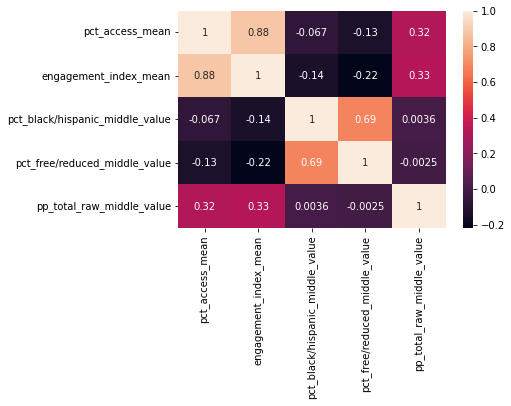

In [ ]:
#@title Correlation Matrix with Heatmap:

# Convert index as int
dist_pct_engagement_mean_df.index = dist_pct_engagement_mean_df.index.astype(int)
# Merge the two dfs
dist_pct_engagement_mean_sf_df = dist_pct_engagement_mean_df.merge(districts_df, how='left', left_index=True, right_on='district_id').set_index('district_id')
# Drop qualitative columns and county_connections_ratio which we don't use
dist_pct_engagement_mean_sf_df.drop(['state', 'locale', 'county_connections_ratio'], axis=1, inplace=True)

# Calculate middle value for the remaining three columns:

def middle_value(df, col):
  lower_limit = []
  upper_limit = []

  for index, row in df.iterrows():
    data = row[col]
    if(not pd.isnull(data)):
      lower_value = data.split(",")[0].split("[")[1]
      upper_value = data.split(",")[1].split("[")[0].strip()
      lower_limit.append(lower_value)
      upper_limit.append(upper_value)
    else:
      lower_limit.append(None)
      upper_limit.append(None)
  
  col_name1 = col + '_lower_limit'
  col_name2 = col + '_upper_limit'
  col_name3 = col + '_middle_value'

  df[col_name1] = lower_limit
  df[col_name2] = upper_limit

  df[col_name1] = pd.to_numeric(lower_limit)
  df[col_name2] = pd.to_numeric(upper_limit)
  df[col_name3] = (df[col_name1] + df[col_name2]) / 2

  return df

for col in dist_pct_engagement_mean_sf_df.columns[2:5]:
  dist_pct_engagement_mean_sf_df = middle_value(dist_pct_engagement_mean_sf_df, col)


# Drop the unuseful columns
dist_pct_engagement_mean_sf_df.drop(['pct_black/hispanic', 
                                     'pct_free/reduced', 
                                     'pp_total_raw', 
                                     'pct_black/hispanic_lower_limit',
                                     'pct_black/hispanic_upper_limit',
                                     'pct_free/reduced_lower_limit',
                                     'pct_free/reduced_upper_limit',
                                     'pp_total_raw_lower_limit',
                                     'pp_total_raw_upper_limit'], axis=1, inplace=True)

# Calculate correlation matrix:
my_corr = dist_pct_engagement_mean_sf_df[['pct_access_mean', 
                                'engagement_index_mean', 
                                'pct_black/hispanic_middle_value', 
                                'pct_free/reduced_middle_value', 
                                'pp_total_raw_middle_value' ]].corr()

sns.heatmap(my_corr, annot=True);

We have merged the information about percentage of minority students and students eligible for free/reduced price lunch into the engagement dataframe. By analyzing the correlation matrix, we can see some reasonable connections:

- Both engagement metrics: pct_access and engagement_index move together (corr of 0.88) as we might expect.
- Percentage of minority students and eligible for free/reduced price lunch have slightly negative correlation. Lower incomes are negatively correlated with digital learning engagement.
- Per-pupil total expenditure data correlates positively with digital learning engagement.

## Q4: How is the digital learning picture for each locale type?

As we have 4 types of locale: Suburb, Rural, City, Town. It would be interesting to see how big is the difference in digital learning among them.

For pct_access: first we compute the max_pct_access as we have done for the districts analysis. Then we average all the districts values among the same type of locale for each day of the 2020. E.g. if 'City' has 20 districts in total, we average the max_pct_access over these 20 districts from Jan. 1st to Dec. 31st. We do so for each of the locale types.

For engagement_index: the only difference is instead of max value, we use the sum for each day aggregated on district level. Then we average over districts. 

In [ ]:
# First, we merge the two datasets:
engagement_districts_df = pd.merge(engagement_df, districts_df, on=['district_id'])
engagement_districts_df.sample(100)

,time,lp_id,pct_access,engagement_index,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw
21793565,2020-12-09,28939.0,0.00,0.00,5006,Massachusetts,Suburb,"[0, 0.2[",NaN,"[0.18, 1[","[14000, 16000["
6500541,2020-10-27,96864.0,0.24,13.04,1877,Illinois,Rural,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[12000, 14000["
7555101,2020-05-21,41424.0,0.01,4.52,3322,California,City,"[0, 0.2[","[0, 0.2[","[0.18, 1[",NaN
2608163,2020-10-01,30762.0,0.00,0.00,3393,NaN,NaN,NaN,NaN,NaN,NaN
10487388,2020-05-07,44853.0,0.01,0.17,1624,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
8353465,2020-03-24,12803.0,0.02,0.45,9303,Massachusetts,Suburb,"[0, 0.2[",NaN,"[0.18, 1[","[14000, 16000["
22321629,2020-12-15,64998.0,1.62,257.40,4165,NaN,NaN,NaN,NaN,NaN,NaN
9082307,2020-08-11,26533.0,0.00,0.00,4569,Connecticut,City,"[0.6, 0.8[","[0.4, 0.6[","[0.18, 1[",NaN
4191566,2020-03-11,10450.0,0.01,1.25,4629,Illinois,Suburb,"[0, 0.2[","[0.2, 0.4[","[0.18, 1[","[16000, 18000["


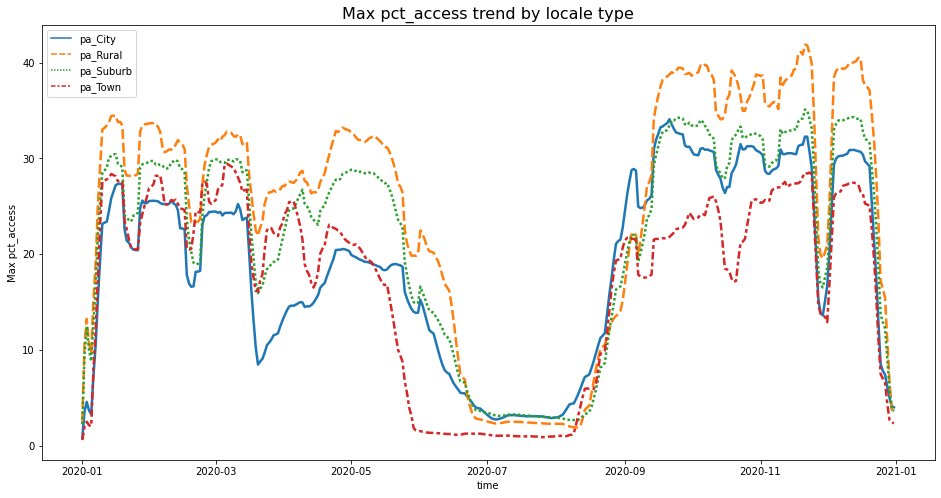

In [ ]:
#@title pct_access metric per locale type:

temp_df = engagement_districts_df.groupby(['locale','district_id', 'time']).pct_access.max()
temp_df = temp_df.to_frame()
locale_pct_access_df = temp_df.groupby(['locale', 'time']).pct_access.mean().to_frame()

def locale_pa():  
  # Create an empty df:
  tot_df = locale_pct_access_df[locale_pct_access_df.index.get_level_values('locale') == 'City']['pct_access'].rolling(7, min_periods=1).mean()
  tot_df = tot_df.to_frame()
  tot_df = tot_df.droplevel('locale', axis=0)
  tot_df.drop(['pct_access'], axis=1, inplace=True)

  # Create a list of locale types
  locale_list = list(locale_pct_access_df.index.unique(level='locale'))

  for locale in locale_list:
    # Extract pct_access values from dataframe:
    pa_df = locale_pct_access_df[locale_pct_access_df.index.get_level_values('locale') == locale]['pct_access'].rolling(7, min_periods=1).mean()
    pa_df = pa_df.to_frame()
    pa_df = pa_df.droplevel('locale', axis=0)
    pa_df.rename(columns={"pct_access": "pa_"+ locale}, inplace=True)

    # Concat to the tot_df
    tot_df = pd.concat([tot_df, pa_df], axis=1)

  # Outside the for loop:
  tot_df.index = pd.to_datetime(tot_df.index)

  # Plot the chart:
  fig, ax = plt.subplots(figsize=(16,8))
  sns.lineplot(data=tot_df, palette='tab10', linewidth=2.5)
  ax.set_title("Max pct_access trend by locale type", size=16)
  ax.set_ylabel('Max pct_access')

# Call the function
locale_pa()

We can see that on average **Rural districts have highest pct_access**, while during the second half of the year **Town districts are performing the worst**. In the second half the difference is widening and became quite considerable with values of Town districts on average **around half** of those of Rural districts.


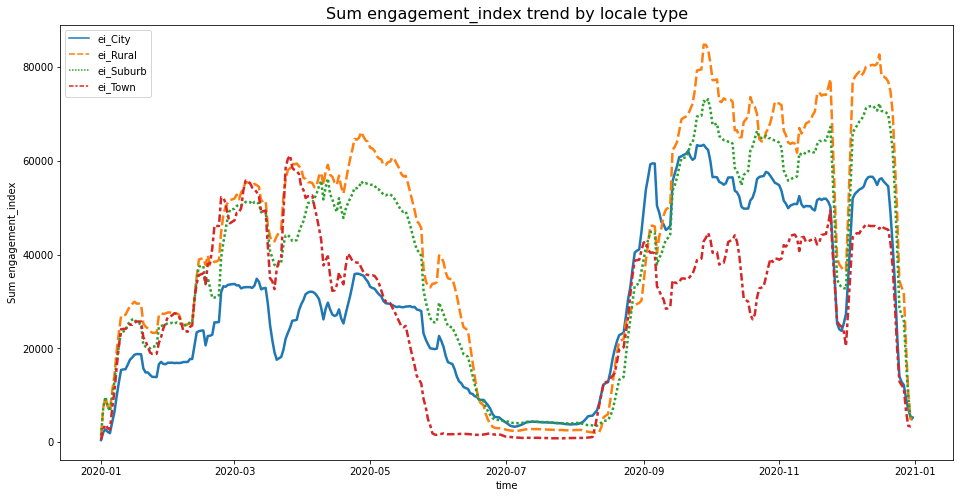

In [ ]:
#@title engagement_index metric per locale type:

temp_df = engagement_districts_df.groupby(['locale','district_id', 'time']).engagement_index.sum()
temp_df = temp_df.to_frame()
locale_engagement_index_df = temp_df.groupby(['locale', 'time']).engagement_index.mean().to_frame()

def locale_ei():  
  # Create an empty df:
  tot_df = locale_engagement_index_df[locale_engagement_index_df.index.get_level_values('locale') == 'City']['engagement_index'].rolling(7, min_periods=1).mean()
  tot_df = tot_df.to_frame()
  tot_df = tot_df.droplevel('locale', axis=0)
  tot_df.drop(['engagement_index'], axis=1, inplace=True)

  # Create a list of locale types
  locale_list = list(locale_engagement_index_df.index.unique(level='locale'))

  for locale in locale_list:
    # Extract pct_access values from dataframe:
    ei_df = locale_engagement_index_df[locale_engagement_index_df.index.get_level_values('locale') == locale]['engagement_index'].rolling(7, min_periods=1).mean()
    ei_df = ei_df.to_frame()
    ei_df = ei_df.droplevel('locale', axis=0)
    ei_df.rename(columns={"engagement_index": "ei_"+ locale}, inplace=True)

    # Concat to the tot_df
    tot_df = pd.concat([tot_df, ei_df], axis=1)

  # Outside the for loop:
  tot_df.index = pd.to_datetime(tot_df.index)

  # Plot the chart:
  fig, ax = plt.subplots(figsize=(16,8))
  sns.lineplot(data=tot_df, palette='tab10', linewidth=2.5)
  ax.set_title("Sum engagement_index trend by locale type", size=16)
  ax.set_ylabel('Sum engagement_index')

# Call the function
locale_ei()

For engagement_index we **also have Rural as the best of the four on average**. We noticed the same difference and trend between Rural and Town as before. While City has trudged in the first half, the second part of year is seeing City districts catching up.

## Q5: Which are the best States? And Which are the worst?

Here we must not hurry to make comparison. We already know that our datasets are not uniform, and there are 4 States who count for more than 55% of the data. Therefore, we first need to establish a cut-off threshold to drop the States with too few data points.

We can see that Florida, Minnesota, Arizona, North Dakota only have 1 school district each. While Minnesota, Arizona, North Dakota, New Hampshire have the fewest data points for both pct_access and engagement_index.

We'll establish a cut-off at 100K data points for both pct_access and engagement_index, and drop States with less than 100K data points. The goal is to allow a certain comparability, as too fewer data will probabily give us a distorted picture of the reality.


In [ ]:
#@title We drop the States of Minnesota, Arizona, North Dakota, New Hampshire from our analysis, as they contain too few districts or examples.

engagement_districts_df.drop(engagement_districts_df[engagement_districts_df.state == 'Minnesota'].index, inplace=True)
engagement_districts_df.drop(engagement_districts_df[engagement_districts_df.state == 'Arizona'].index, inplace=True)
engagement_districts_df.drop(engagement_districts_df[engagement_districts_df.state == 'North Dakota'].index, inplace=True)
engagement_districts_df.drop(engagement_districts_df[engagement_districts_df.state == 'New Hampshire'].index, inplace=True)
engagement_districts_df.drop(engagement_districts_df[engagement_districts_df.state == 'Not disclosed'].index, inplace=True)


We decide to compute the average value amongs all districts in a given State as the State value. So to recap:

- For pct_access: we calculate the daily max pct_access for the whole year for each district in the State, we average them out to get State level metric.

- For the engagement_index: we used the sum instead of max value. So we have the cumulative daily value for the whole year for each district in the State. As above, we average them out among all districts to come up with the State level metric.


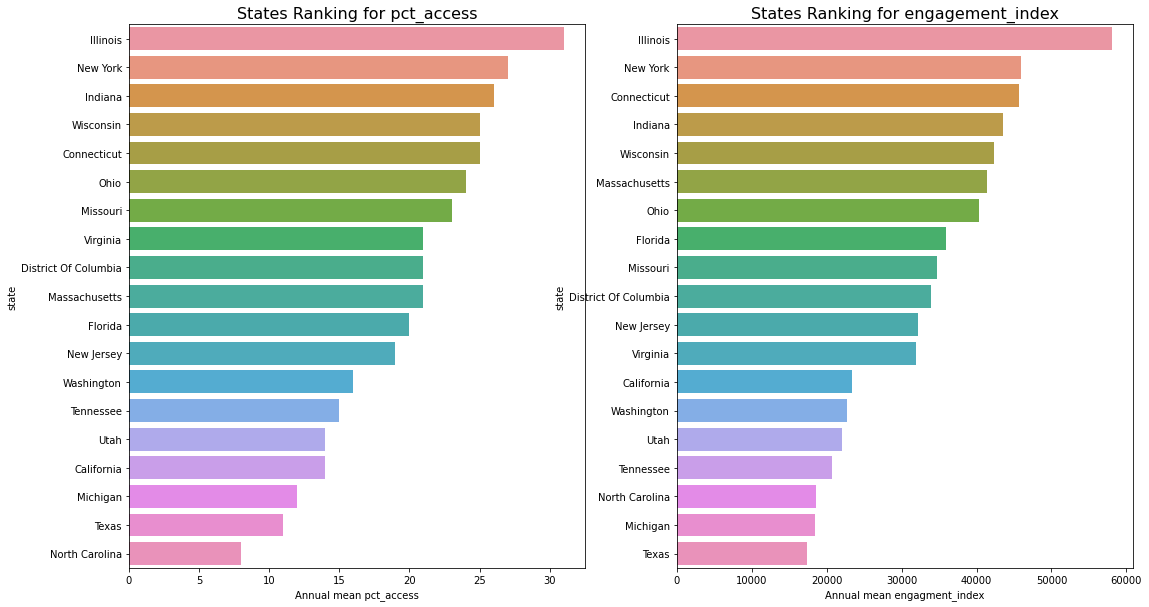

In [ ]:
#@title State level **pct_access** and **engagement_index** ranking:

# states_pct_access_df.loc['California']
# states_pct_access_df.loc['California'].mean(axis=0).head(20)
# df = pd.DataFrame(states_pct_access_df.loc['California'].mean(axis=0))
# df.index = df.index.droplevel()
# df.transpose()

# Extract pct_access data from the df:
states_pct_access_df = engagement_districts_df.groupby(['state', 'district_id', 'time']).pct_access.max().to_frame().unstack()

# Create a new temporary DataFrame with States as index:
states_index = states_pct_access_df.index.get_level_values(level=0).drop_duplicates()
states_pct_index = pd.DataFrame(index=states_index)

frames = []

# For each State we calculate the mean of pct_access among its districts:
for state, sub_df in states_pct_access_df.groupby(level=0):
  new_df = pd.DataFrame(states_pct_access_df.loc[state].mean(axis=0))
  new_df.index = new_df.index.droplevel()
  frames.append(new_df.transpose())

states_pct_temp = pd.concat(frames)
states_pct_mean_df = states_pct_temp.set_index(states_pct_index.index)

# States Ranking for pct_access:
states_pa = states_pct_mean_df.mean(axis=1).sort_values(ascending=False).to_frame()

# plt.figure(figsize=(20,10))
# sns.barplot(x=states_pa.values.flatten().astype('int'), y=states_pa.index)
# plt.title('States Ranking for pct_access', size=20)
# plt.ylabel('States')
# plt.xlabel('Annual mean pct_access');


# Extract engagement_index data from the df:
states_engagement_index_df = engagement_districts_df.groupby(['state', 'district_id', 'time']).engagement_index.sum().to_frame().unstack()

# Create a new temporary DataFrame with States as index:
states_index = states_engagement_index_df.index.get_level_values(level=0).drop_duplicates()
states_engagement_index_index = pd.DataFrame(index=states_index)

frames = []

for state, sub_df in states_engagement_index_df.groupby(level=0):
  new_df = pd.DataFrame(states_engagement_index_df.loc[state].mean(axis=0))
  new_df.index = new_df.index.droplevel()
  frames.append(new_df.transpose())

states_engagement_temp = pd.concat(frames)
# engagement_index for each State:
states_engagement_mean_df = states_engagement_temp.set_index(states_engagement_index_index.index)

# States Ranking for engagement_index:
states_ei = states_engagement_mean_df.mean(axis=1).sort_values(ascending=False).to_frame()


# plt.figure(figsize=(20,10))
# sns.barplot(x=states_ei.values.flatten().astype('int'), y=states_ei.index)
# plt.title('States Ranking for engagement_index', size=20)
# plt.ylabel('States')
# plt.xlabel('Annual mean engagment_index');

#Plot the charts:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(18, 10))

sns.barplot(x=states_pa.values.flatten().astype('int'), y=states_pa.index, ax=ax0)
ax0.set_title('States Ranking for pct_access', size=16)
ax0.set_xlabel('Annual mean pct_access')

sns.barplot(x=states_ei.values.flatten().astype('int'), y=states_ei.index, ax=ax1)
ax1.set_title('States Ranking for engagement_index', size=16)
ax1.set_xlabel('Annual mean engagment_index')

plt.show();

In [ ]:
#@title Split numerical features into upper and lower limits:

def percentage_columns(df, col):
  lower_limit = []
  upper_limit = []

  for index, row in df.iterrows():
    data = row[col]
    if(not pd.isnull(data)):
      lower_value = data.split(",")[0].split("[")[1]
      upper_value = data.split(",")[1].split("[")[0].strip()
      lower_limit.append(lower_value)
      upper_limit.append(upper_value)
    else:
      lower_limit.append(None)
      upper_limit.append(None)
  
  col_name1 = col + '_lower_limit'
  col_name2 = col + '_upper_limit'
  col_name3 = col + '_range'
  df[col_name1] = lower_limit
  df[col_name2] = upper_limit
  df[col_name3] = df[col_name1] + '-' + df[col_name2]

  return df


districts_copy = districts_df.copy()
for col in districts_copy.columns[3:7]:
  districts_copy = percentage_columns(districts_copy, col)

# districts_copy = districts_copy.dropna()


In [ ]:
#@title Define Plotting Functions:

def filter_state(df, col, state):
  return df[['state', 'district_id', col]].dropna().loc[df['state']==state]

def display(df, state):
  col1 = 'pct_black/hispanic_range'
  col2 = 'pct_free/reduced_range'
  col3 = 'pp_total_raw_range'
  col4 = 'locale'

  df1 = filter_state(df, col1, state)
  df2 = filter_state(df, col2, state)
  df3 = filter_state(df, col3, state)
  df4 = filter_state(df, col4, state)

  # Plot the charts
  fig, ax = plt.subplots(2,2, figsize=(16,16))
  fig.suptitle(state + "'s Characteristics", fontweight='bold', fontsize=20)

  plot_order1 = sorted(list(df1[col1].unique()))
  sns.countplot(y=col1, data=df1, order=plot_order1, ax=ax[0,0])
  ax[0,0].set_title('% of Black/Hispanic')
  ax[0,0].set_ylabel(None)

  plot_order2 = sorted(list(df2[col2].unique()))
  sns.countplot(y=col2, data=df2, order=plot_order2, ax=ax[0,1])
  ax[0,1].set_title('% of Eligible for Free/Reduced Lunch Price')
  ax[0,1].set_ylabel(None)

  plot_order3 = sorted(list(df3[col3].unique()))
  sns.countplot(y=col3, data=df3, order=plot_order3, ax=ax[1,0])
  ax[1,0].set_title('Per-pupil total expenditure')
  ax[1,0].set_ylabel(None)

  sns.countplot(y=col4, data=df4, ax=ax[1,1])
  ax[1,1].set_title('Locale distribution')
  ax[1,1].set_ylabel(None)

  # plt.tight_layout()
  plt.show()

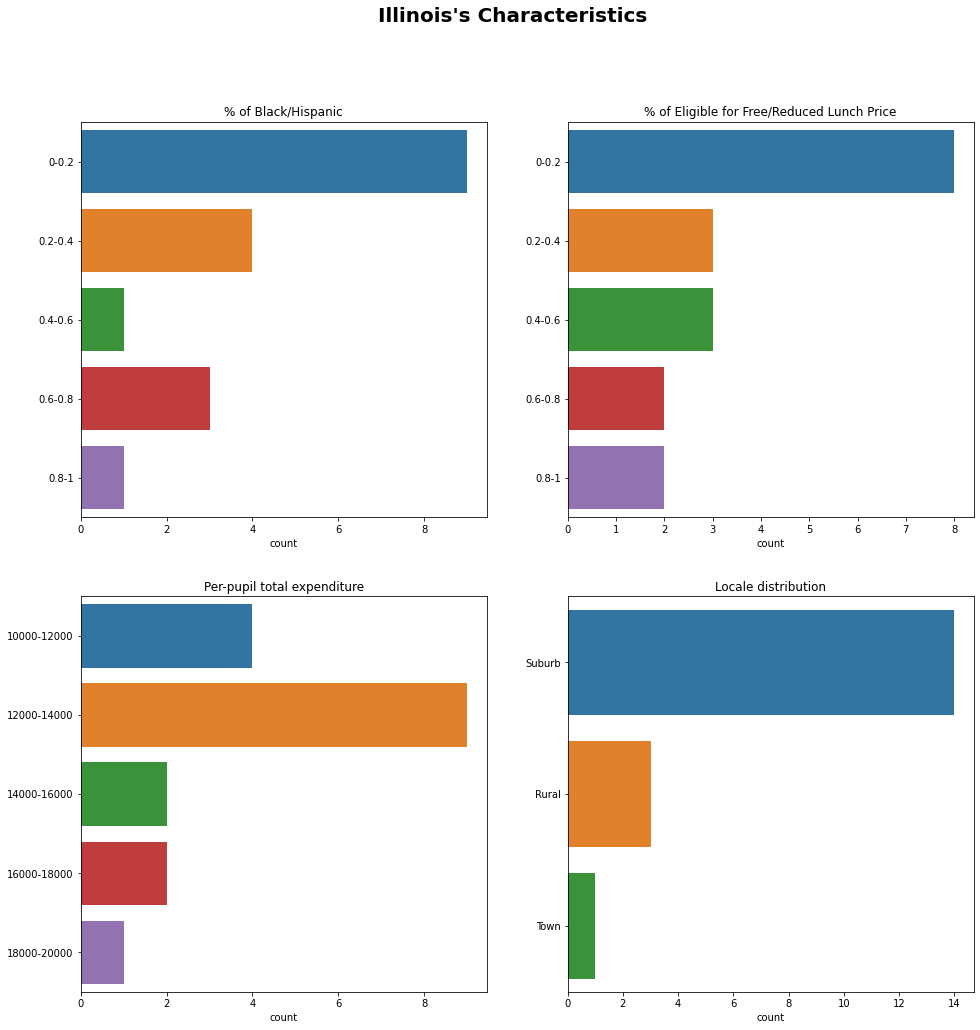

In [ ]:
#@title Insert the name of the State to see its characteristics:

state_name = 'Illinois' #@param {type:"string"}

display(districts_copy, state_name)

Here we have some confirmation with our previous analysis on districs:

- Best States consist of: **Illinois, New York, Indiana, Connecticut, Wisconsin**. 
- While at bottom of the ranking we can find: **Texas, Michigan, North Carolina**. *(Might partially due to the lower sample size of data. We can't have a more confident conclusion unless we have more data on these States.)*
- **California**'s performance are quite bad compared to the best. Both metrics pct_access and engagement_index are only 1/2 of those at top of the ranking.
- From a preliminary analysis of the characteristics of each State in both best and worst rankings. We have noticed that the percentage of Black/Hispanic Students and Eligible for Free/Reduced Lunch Price are both generally high in the worst States and generally low in the best States. Which indicates **a negative correlation between families' economic conditions and usage of digital learning tools**. This finding matches with our previous analysis on Correlation Matrix with both pct_black/hispanic and pct_free/reduced having negative correlation values around -0.20.

#Let's focus now on our digital learning products:

## Load products_info data into DataFrame

### Product information data
> The product file ```products_info.csv``` includes information about the characteristics of the top 372 products with most users in 2020. The categories listed in this file are part of LearnPlatform's product taxonomy. 

📝 Some products may not have labels due to being duplicate, lack of accurate url or other reasons.

| Name                       | Description                                                                                                                                                                                                                                                                                                                    |
|----------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| LP ID                      | The unique identifier of the product                                                                                                                                                                                                                                                                                           |
| URL                        | Web Link to the specific product                                                                                                                                                                                                                                                                                               |
| Product Name               | Name of the specific product                                                                                                                                                                                                                                                                                                   |
| Provider/Company Name      | Name of the product provider                                                                                                                                                                                                                                                                                                   |
| Sector(s)                  | Sector of education where the product is used                                                                                                                                                                                                                                                                                  |
| Primary Essential Function | The basic function of the product. There are two layers of labels here. Products are first labeled as one of these three categories: LC = Learning & Curriculum, CM = Classroom Management, and SDO = School & District Operations. Each of these categories have multiple sub-categories with which the products were labeled |
|                            |                                                                                                                                                                         

We split the Primary Essential Function into two separate columns as there are two layers/levels of specifications here.

In [ ]:
products_df = pd.read_csv('/content/learnplatform-covid19-impact-on-digital-learning/products_info.csv')

In [ ]:
products_df

,LP ID,URL,Product Name,Provider/Company Name,Sector(s),Primary Essential Function
0,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms
1,66933,https://abcmouse.com,ABCmouse.com,"Age of Learning, Inc",PreK-12,LC - Digital Learning Platforms
2,50479,https://www.abcya.com,ABCya!,"ABCya.com, LLC",PreK-12,"LC - Sites, Resources & Reference - Games & Si..."
3,92993,http://www.aleks.com/,ALEKS,McGraw-Hill PreK-12,PreK-12; Higher Ed,LC - Digital Learning Platforms
4,73104,https://www.achieve3000.com/,Achieve3000,Achieve3000,PreK-12,LC - Digital Learning Platforms
...,...,...,...,...,...,...
367,88065,https://dochub.com/,DocHub,DocHub,PreK-12; Higher Ed; Corporate,SDO - Other
368,37805,http://google.com/slides/about/,Google Slides,Google LLC,PreK-12; Higher Ed; Corporate,LC - Content Creation & Curation
369,32555,http://www.innersloth.com/gameAmongUs.php,Among Us,InnerSloth,PreK-12; Higher Ed,"LC - Sites, Resources & Reference - Games & Si..."
370,87841,http://edpuzzle.com,Edpuzzle - Free (Basic Plan),EDpuzzle Inc.,NaN,NaN


As per instruction, the last column 'Primary Essential Function' actually contains two layers of information. As first thing, we therefore split it as following:

In [ ]:
products_df['func_category']= products_df['Primary Essential Function'].str.split(' - ', 1).str[0]
products_df['primary_function']= products_df['Primary Essential Function'].str.split(' - ', 1).str[1]
products_df

,LP ID,URL,Product Name,Provider/Company Name,Sector(s),Primary Essential Function,func_category,primary_function
0,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms,LC,Digital Learning Platforms
1,66933,https://abcmouse.com,ABCmouse.com,"Age of Learning, Inc",PreK-12,LC - Digital Learning Platforms,LC,Digital Learning Platforms
2,50479,https://www.abcya.com,ABCya!,"ABCya.com, LLC",PreK-12,"LC - Sites, Resources & Reference - Games & Si...",LC,"Sites, Resources & Reference - Games & Simulat..."
3,92993,http://www.aleks.com/,ALEKS,McGraw-Hill PreK-12,PreK-12; Higher Ed,LC - Digital Learning Platforms,LC,Digital Learning Platforms
4,73104,https://www.achieve3000.com/,Achieve3000,Achieve3000,PreK-12,LC - Digital Learning Platforms,LC,Digital Learning Platforms
...,...,...,...,...,...,...,...,...
367,88065,https://dochub.com/,DocHub,DocHub,PreK-12; Higher Ed; Corporate,SDO - Other,SDO,Other
368,37805,http://google.com/slides/about/,Google Slides,Google LLC,PreK-12; Higher Ed; Corporate,LC - Content Creation & Curation,LC,Content Creation & Curation
369,32555,http://www.innersloth.com/gameAmongUs.php,Among Us,InnerSloth,PreK-12; Higher Ed,"LC - Sites, Resources & Reference - Games & Si...",LC,"Sites, Resources & Reference - Games & Simulat..."
370,87841,http://edpuzzle.com,Edpuzzle - Free (Basic Plan),EDpuzzle Inc.,NaN,NaN,NaN,NaN


In [ ]:
print(products_df["LP ID"].nunique())
print(engagement_df["lp_id"].nunique())

372
8647


We can see from above that in the products_df we have the top 372 products information, while in our engagement_df we have a lot more products. So we have to be careful when we merge the datasets.

## Exploratory Data Analysis on Products:

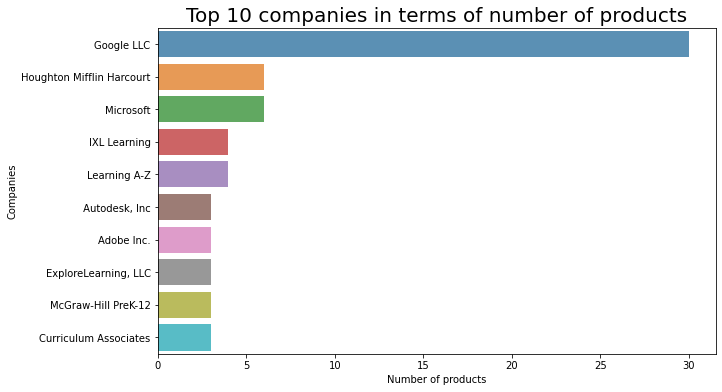

In [ ]:
#@title Top 10 companies in terms of number of products:

companies_num_prod = products_df['Provider/Company Name'].value_counts(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x = companies_num_prod.values, y = companies_num_prod.index, alpha=0.8)
plt.title('Top 10 companies in terms of number of products', size=20)
plt.ylabel('Companies')
plt.xlabel('Number of products')
plt.show();

The chart shows the importance of Google for digital learning, although we still have to dig deep on which specific products are the most used by the students. 

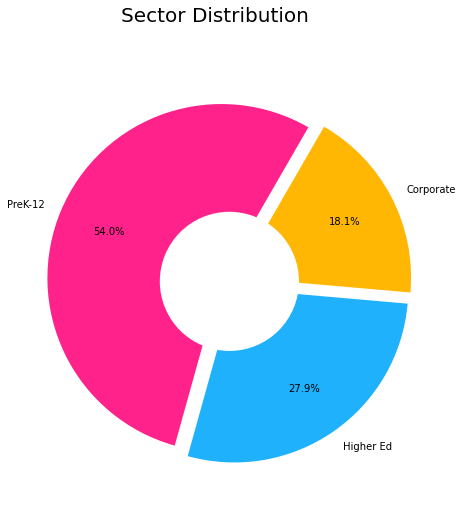

In [ ]:
#@title Sectors Distribution:

c1=c2=c3=0
for s in products_df["Sector(s)"]:
    if(not pd.isnull(s)):
        s = s.split(";")
        for i in range(len(s)):
            sub = s[i].strip()
            if(sub == 'PreK-12'): c1+=1
            if(sub == 'Higher Ed'): c2+=1
            if(sub == 'Corporate'): c3+=1

fig, ax  = plt.subplots(figsize=(16, 8))
fig.suptitle('Sector Distribution', size = 20)
explode = (0.05, 0.05, 0.05)
labels = ['PreK-12','Higher Ed','Corporate']
sizes = [c1,c2, c3]
ax.pie(sizes, explode=explode,startangle=60, labels=labels,autopct='%1.1f%%', pctdistance=0.7, colors=["#ff228a","#20b1fd","#ffb703"])
ax.add_artist(plt.Circle((0,0),0.4,fc='white'))
plt.show();

The majority of products are PreK-12, this matches well with our goal of analysis.

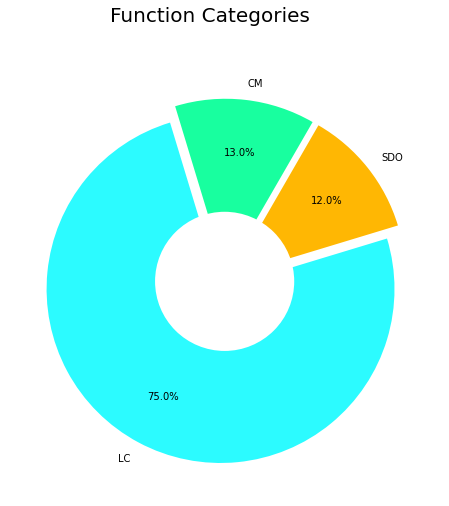

In [ ]:
#@title Function Categories Distribution:

c1=c2=c3=0

for s in products_df["func_category"]:
    if(not pd.isnull(s)):
        c1 += s.count("CM")
        c2 += s.count("LC")
        c3 += s.count("SDO")

fig, ax  = plt.subplots(figsize=(16, 8))
fig.suptitle('Function Categories', size = 20)
explode = (0.05, 0.05, 0.05)
labels = ['CM','LC','SDO']
sizes = [c1, c2, c3]
ax.pie(sizes, explode=explode,startangle=60, labels=labels,autopct='%1.1f%%', pctdistance=0.7, colors=["#18ff9f","#2cfbff","#ffb703"])
ax.add_artist(plt.Circle((0,0),0.4,fc='white'))
plt.show()

 LC = Learning & Curriculum is the overwhelming majority function category, which matches well with our objective.

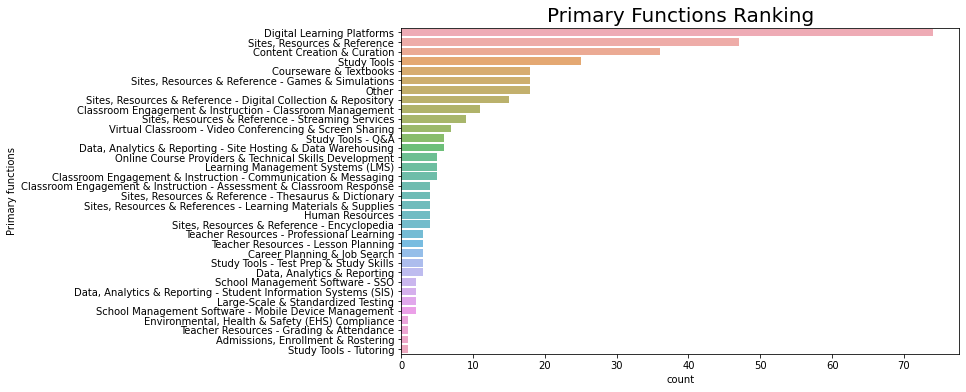

In [ ]:
#@title Primary Functions Ranking:

func_dist = products_df['primary_function'].value_counts(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x = func_dist.values, y = func_dist.index, alpha=0.8)
plt.title('Primary Functions Ranking', size=20)
plt.ylabel('Primary functions')
plt.xlabel('count')
plt.show();

As expected the higher counts (higher number of technology products) are related to functions focused on students learning like: Digital Learning Platforms, Resources & Reference, Content Creation & Curation. 

While the lower end is populated with school management software, admissions, enrollment, teacher resources etc.

## Now we want to see more about the relationship betweeen technology products and their engagement metrics.

## Merge products_df with engagement_df

Now we merge the two DataFrames. Keep in mind that we have the top 372 products information in products_df, while in our engagement_df we have a lot more around 8600 products majority of which we don't have information.

Here we will filter out all the engagements rows which don't have a `lp_id` included in our products dataframe. We can see that from the previous 22M rows we are down to 11M rows now. 

In [ ]:
products_engagement_df = pd.merge(products_df, engagement_df, left_on='LP ID', right_on='lp_id')
products_engagement_df

,LP ID,URL,Product Name,Provider/Company Name,Sector(s),Primary Essential Function,func_category,primary_function,time,lp_id,pct_access,engagement_index,district_id
0,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms,LC,Digital Learning Platforms,2020-01-08,13117.0,0.00,0.00,3393
1,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms,LC,Digital Learning Platforms,2020-01-09,13117.0,0.00,0.00,3393
2,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms,LC,Digital Learning Platforms,2020-01-10,13117.0,0.04,0.38,3393
3,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms,LC,Digital Learning Platforms,2020-01-13,13117.0,0.00,0.00,3393
4,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms,LC,Digital Learning Platforms,2020-01-14,13117.0,0.00,0.00,3393
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11691582,87841,http://edpuzzle.com,Edpuzzle - Free (Basic Plan),EDpuzzle Inc.,NaN,NaN,NaN,NaN,2020-12-19,87841.0,0.02,0.26,7614
11691583,87841,http://edpuzzle.com,Edpuzzle - Free (Basic Plan),EDpuzzle Inc.,NaN,NaN,NaN,NaN,2020-12-23,87841.0,0.01,0.09,7614
11691584,87841,http://edpuzzle.com,Edpuzzle - Free (Basic Plan),EDpuzzle Inc.,NaN,NaN,NaN,NaN,2020-12-28,87841.0,0.02,0.17,7614
11691585,87841,http://edpuzzle.com,Edpuzzle - Free (Basic Plan),EDpuzzle Inc.,NaN,NaN,NaN,NaN,2020-12-30,87841.0,0.01,0.95,7614


## Q6: Which are the products most frequently used during 2020?

For product metrics we have made the following choices:

- For **pct_access**: we average among all the districts to come up with values for each product. Previously for the district we used the max value instead of mean value. This is because we were interested to have a picture exclusively on a district level without considering which product on any given day had the highest pct_access. In other words, we mixed the metric among all available products (8600 of them). While here we choose not to mix the metric among districts, because that would make the picture on product more fuzzy. So we choose to average pct_access among districts instead.

- For **engagement_index**: we replicate the same procedure as for districts, so we sum up the metric on district level. And then we average among all districts for each product.

In [ ]:
#@title Top 10 products on annual average pct_access:

# pct_access average over districts per each product (year: 2020)
product_pct_access_df = products_engagement_df.groupby(['Product Name', 'time']).pct_access.mean().to_frame()

# Annual average max_pct_access per product:
product_avg_pct_access_df = product_pct_access_df.groupby(level=0).transform('mean').reset_index().groupby('Product Name').first() # Averaging over the year
product_avg_pct_access_df.drop(['time'], axis=1, inplace=True)
product_avg_pct_access_df.rename(columns={'pct_access': 'annual_pct_access'}, inplace=True)
product_avg_pct_access_df.sort_values(by=['annual_pct_access'], ascending=False).head(10)

,annual_pct_access
Product Name,
Google Classroom,15.676489
Google Docs,15.048582
YouTube,8.120754
Google Drive,7.980854
ClassLink,6.493597
Google Forms,5.915355
Meet,5.699076
Canvas,5.501135
Clever,5.481591


- We can see that **Google** has 6 products among the top10. Even though Youtube can have also leisure usage mixed up there. 
- At position no.5 we have [**ClassLink**](https://www.classlink.com), which is a one click single sign-on solution for students to access all the resources, applications, and school files. 
- At position no.8 [**Canvas**](https://www.instructure.com/en-gb/canvas) is a web-based learning management system, or LMS. It is used by learning institutions, educators, and students to access and manage online course learning materials and communicate about skill development and learning achievement.

- At position no.9 [**Clever**](https://clever.com/) is a platform for resources, messaging, and analytics for students, families and educators. 
- At no.10 we have **Zoom** to complete the top10 list.


The pct_access numbers seem strangely low. But we have to remember that here we have averaged among all districts. Since quite a lot of bottom districts have pct_access close to zero, so by averaging values the overall metrics have been pulled downwards. If we choose to use max() we would have come up with values between 30 to 55, but that would be the picture of the best districts. Here we need an overall picture among all districts. So it is ok that they remain low.



In [ ]:
#@title Top 10 products on annual average engagement_index:

# engagement_index average over districts per each product (year: 2020)
product_engagement_index_df = products_engagement_df.groupby(['Product Name', 'district_id' ,'time']).engagement_index.sum().to_frame()
product_engagement_index_df = product_engagement_index_df.groupby(['Product Name','time']).engagement_index.mean().to_frame()


# Annual average engagement_index per product:
product_avg_engagement_index_df = product_engagement_index_df.groupby(level=0).transform('mean').reset_index().groupby('Product Name').first() # Averaging over the year
product_avg_engagement_index_df.drop(['time'], axis=1, inplace=True)
product_avg_engagement_index_df.rename(columns={'engagement_index': 'annual_engagement_index'}, inplace=True)
product_avg_engagement_index_df.sort_values(by=['annual_engagement_index'], ascending=False).head(10)


,annual_engagement_index
Product Name,
Google Docs,9689.493701
Google Classroom,4957.213865
YouTube,3197.423856
Canvas,2152.600732
Meet,1556.688407
Schoology,1278.457514
Kahoot!,1231.951403
Google Forms,776.930439
Google Drive,748.208234


We have confirmation from engagement_index metric that **Google** has 6 products among the top10. But we also have some interesting new entries like: **Kahoot!** and [**Schoology**](https://www.schoology.com/).

Since we didn't know about Schoology, we went out to find some extra information. For whom might want to know more about this product and company, you can download the presentation here: [Presentation PDF](https://www.redclayschools.com/cms/lib/DE01903704/Centricity/Domain/709/Parent%20Schoology%20Red%20Clay%20Presentation.pdf).

![](https://drive.google.com/uc?export=view&id=1gPREmNozmcURJ2C_uQUeqXO0ehsgPyQe)




## Virtual Classroom Products Analysis:

Now we want to do some deeper analysis on some specific type of technology products. In particular, we are interested in 'Virtual Classroom' products as they should be the most important tool for the students during pandemic.

## Q7: In the video-communication service, how was the students' engagement?

In [ ]:
#@title Create function to plot pct_access for products:

def products_pa(*args):  # pass a number of products you want
  
  # Create an empty df:
  tot_df = product_pct_access_df[product_pct_access_df.index.get_level_values('Product Name') == 'Google Classroom']['pct_access'].rolling(7, min_periods=1).mean()
  tot_df = tot_df.to_frame()
  tot_df = tot_df.droplevel('Product Name', axis=0)
  tot_df.drop(['pct_access'], axis=1, inplace=True)

  for prod in args:
    # Extract pct_access_max from the original dataframe:
    pa_df = product_pct_access_df[product_pct_access_df.index.get_level_values('Product Name') == str(prod)]['pct_access'].rolling(7, min_periods=1).mean()
    pa_df = pa_df.to_frame()
    pa_df = pa_df.droplevel('Product Name', axis=0)
    pa_df.rename(columns={"pct_access": "pa_"+str(prod)}, inplace=True)

    # Concat to the tot_df
    tot_df = pd.concat([tot_df, pa_df], axis=1)

  # Outside the for loop:
  tot_df.index = pd.to_datetime(tot_df.index)

  # Plot the chart:
  fig, ax = plt.subplots(figsize=(16,8))
  sns.lineplot(data=tot_df, palette='tab10', linewidth=2.5)
  ax.set_title("pct_access for selected products", size=16)
  ax.set_ylabel('pct_access')




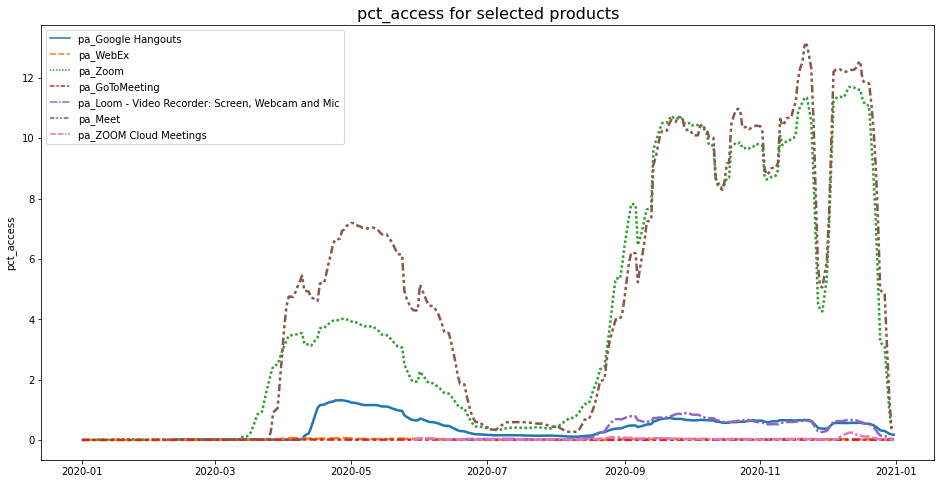

In [ ]:
# Extract Product Names of Virtual Classroom Tools:
virtual_class = list(products_df[products_df['primary_function'] == 'Virtual Classroom - Video Conferencing & Screen Sharing']['Product Name'])

# Call the function to plot the chart:
products_pa(*virtual_class)

In [ ]:
#@title Create function to plot engagement_index for products:

def products_ei(*args):  # pass a number of products you want
  
  # Create an empty df:
  tot_df = product_engagement_index_df[product_engagement_index_df.index.get_level_values('Product Name') == 'Google Classroom']['engagement_index'].rolling(7, min_periods=1).mean()
  tot_df = tot_df.to_frame()
  tot_df = tot_df.droplevel('Product Name', axis=0)
  tot_df.drop(['engagement_index'], axis=1, inplace=True)

  for prod in args:
    # Extract engagement_index from the original dataframe:
    ei_df = product_engagement_index_df[product_engagement_index_df.index.get_level_values('Product Name') == str(prod)]['engagement_index'].rolling(7, min_periods=1).mean()
    ei_df = ei_df.to_frame()
    ei_df = ei_df.droplevel('Product Name', axis=0)
    ei_df.rename(columns={"engagement_index": "ei_"+str(prod)}, inplace=True)

    # Concat to the tot_df
    tot_df = pd.concat([tot_df, ei_df], axis=1)

  # Outside the for loop:
  tot_df.index = pd.to_datetime(tot_df.index)

  # Plot the chart:
  fig, ax = plt.subplots(figsize=(16,8))
  sns.lineplot(data=tot_df, palette='tab10', linewidth=2.5)
  ax.set_title("engagement_index for selected products", size=16)
  ax.set_ylabel('engagement_index')



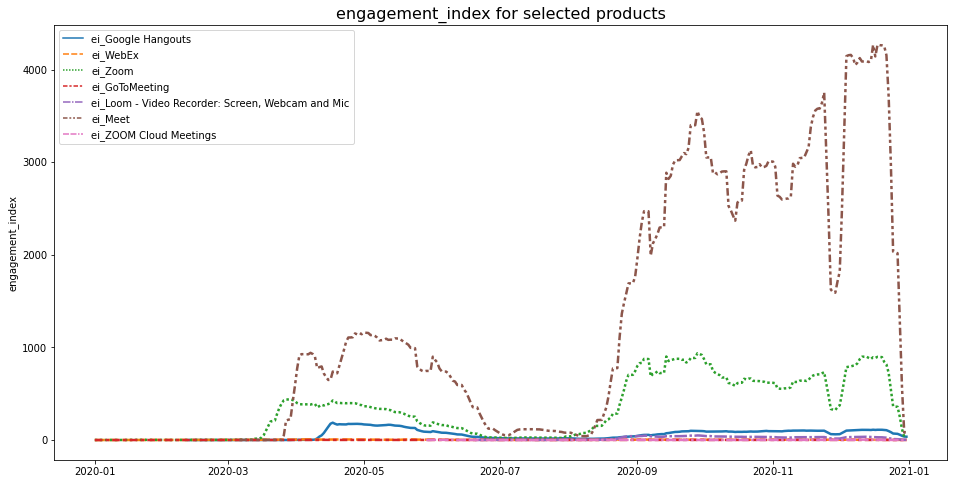

In [ ]:
products_ei(*virtual_class)

Analysis of Virtual Classroom productscan be summarized as following:

- **Google Meet and Zoom** are the two most used tools. We can see that for the pct_access they are practically the same (an equivalent percentage of students use one or another). However **for engagement_index Google Meet beats definitely Zoom** (Meet has more than 4 times page-load events than Zoom).
For example if we have 1000 page-load events per 1000 students for Zoom on a given day that means that one student uses Zoom once a day. In contrast, Meet is used 4 or 5 times daily on average per student.

- **Smaller players** don't have much market share. For virtual classrooms consumers tend to rely on big names.

- The usage of these tools really **took off in the month of March** when the pandemic broke out and schools have been closed.

- **After the summer holidays the usage became even stronger**. We can imagine students getting used to such digital tools as time goes by. 

One thing to notice here: the absolute values of both metrics seem very low. The reason is that as we have averaged among all 233 districts, there is a drag down effect. We have already seen that the difference between top10 districts and bottom10 is very big around 10x. So here we should pay more attention on the comparison of the difference between products, and ignore the meaning of the absolute values. 

To further confirmed that absolute values have been dragged down. We plot the chart for a set of best districts and make a confrontation between three virtual classroom products: Meet, Zoom, Google Hangouts.

In [ ]:
#@title pct_access districts products cross analysis:

def districts_products_pa(districts, products):

  # Create an empty df:
  tot_df = product_pct_access_df[product_pct_access_df.index.get_level_values('Product Name') == 'Google Classroom']['pct_access'].rolling(7, min_periods=1).mean()
  tot_df = tot_df.to_frame()
  tot_df = tot_df.droplevel('Product Name', axis=0)
  tot_df.drop(['pct_access'], axis=1, inplace=True)

  for dist in districts:
    for prod in products:
      pa_dp = products_engagement_df[(products_engagement_df['district_id'] == int(dist)) & (products_engagement_df['Product Name'] == str(prod))][['time','pct_access']]
      pa_dp.set_index('time', inplace=True)
      pa_dp['pct_access'] = pa_dp['pct_access'].rolling(7, min_periods=1).mean()
      pa_dp.rename(columns={'pct_access': 'pa_'+str(dist)+'_'+ str(prod)}, inplace=True)

      # Concat to the tot_df
      tot_df = pd.concat([tot_df, pa_dp], axis=1)
    
  # Outside the for loop:
  tot_df.index = pd.to_datetime(tot_df.index)

  # Plot the chart:
  fig, ax = plt.subplots(figsize=(16,8))
  sns.lineplot(data=tot_df, palette='tab10', linewidth=2.5)
  ax.set_title("pct_access for selected districts and products", size=16)
  ax.set_ylabel('pct_access')


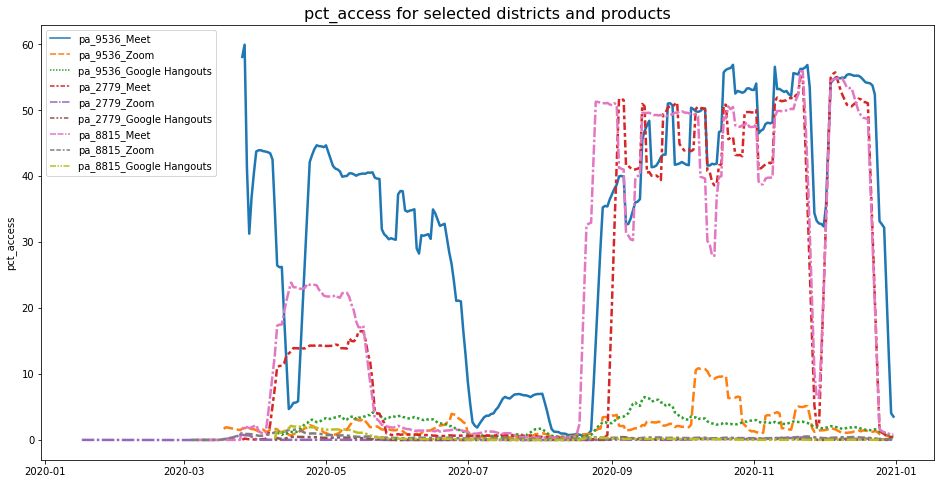

In [ ]:
dist_list = [9536, 2779, 8815]                       # three of the best districts
prod_list = ['Meet', 'Zoom', 'Google Hangouts']      # products we're interested in

# Call the function to plot the chart:
districts_products_pa(dist_list, prod_list)

Notice how pct_access is in the range 40-60, indicating 40-60% of students in these districts have at least one page-load event during the period. 

We can clearly see that Meet is the most used product among these three districts. The district no.9536 also uses Zoom and Google Hangouts in a marginal way, while other two don't use them at all.

In [ ]:
#@title engagement_index districts products cross analysis:

def districts_products_ei(districts, products):

  # Create an empty df:
  tot_df = product_pct_access_df[product_pct_access_df.index.get_level_values('Product Name') == 'Google Classroom']['pct_access'].rolling(7, min_periods=1).mean()
  tot_df = tot_df.to_frame()
  tot_df = tot_df.droplevel('Product Name', axis=0)
  tot_df.drop(['pct_access'], axis=1, inplace=True)

  for dist in districts:
    for prod in products:
      ei_dp = products_engagement_df[(products_engagement_df['district_id'] == int(dist)) & (products_engagement_df['Product Name'] == str(prod))][['time','engagement_index']]
      ei_dp.set_index('time', inplace=True)
      ei_dp['engagement_index'] = ei_dp['engagement_index'].rolling(7, min_periods=1).mean()
      ei_dp.rename(columns={'engagement_index': 'ei_'+str(dist)+'_'+ str(prod)}, inplace=True)

      # Concat to the tot_df
      tot_df = pd.concat([tot_df, ei_dp], axis=1)
    
  # Outside the for loop:
  tot_df.index = pd.to_datetime(tot_df.index)

  # Plot the chart:
  fig, ax = plt.subplots(figsize=(16,8))
  sns.lineplot(data=tot_df, palette='tab10', linewidth=2.5)
  ax.set_title("engagement_index for selected districts and products", size=16)
  ax.set_ylabel('engagement_index')

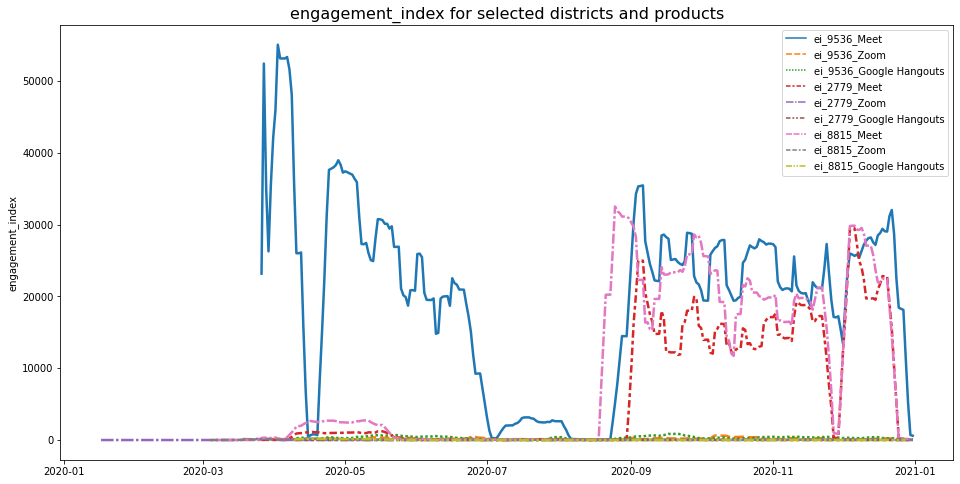

In [ ]:
dist_list = [9536, 2779, 8815]                       # three of the best districts
prod_list = ['Meet', 'Zoom', 'Google Hangouts']      # products we're interested in

# Call the function to plot the chart:
districts_products_ei(dist_list, prod_list)

As expected engagement_index confirms what pct_access has shown.

## Digital Learning Platforms, Study Tools, Content Creation & Curation products analysis

Above we have analyzed in detail the subcategory of `'Virtual Classroom - Video Conferencing & Screen Sharing'`. We went through the list of primary_function in the DataFrame, and noticed that the following subcategories are worth a detailed look too:
- `'Digital Learning Platforms'` with notable names such as: **Duolingo**, **Khan Academy**.
- `'Study Tools'` including: **Chegg**, **CliffsNotes**, **Desmos**, **GeoGebra**, **Kahoot!**, **Quizlet**.
- `'Content Creation & Curation'` including: **Google Docs**, **Google Slides**, **Scratch**.

In particular we would like to see which tools are the most frequently used in each of the above three subcategories.

In [ ]:
# List of the primary_function/subcategories:
products_df['primary_function'].unique()

In [ ]:
# Products in the subcategory of 'Study Tools':
products_df[products_df['primary_function']== 'Study Tools']

,LP ID,URL,Product Name,Provider/Company Name,Sector(s),Primary Essential Function,func_category,primary_function
10,89802,http://bartleby.com/,Bartleby,Bartleby,PreK-12; Higher Ed,LC - Study Tools,LC,Study Tools
18,50104,http://www.chegg.com/,Chegg,Chegg,PreK-12; Higher Ed,LC - Study Tools,LC,Study Tools
21,96116,http://www.cliffsnotes.com,CliffsNotes,Houghton Mifflin Harcourt,PreK-12; Higher Ed,LC - Study Tools,LC,Study Tools
24,64947,http://www.desmos.com,Desmos,Desmos,PreK-12; Higher Ed,LC - Study Tools,LC,Study Tools
33,57724,http://www.easybib.com/,EasyBib,Imagine Easy Solutions,PreK-12; Higher Ed,LC - Study Tools,LC,Study Tools
...,...,...,...,...,...,...,...,...
276,79578,https://flippity.net/,Flippity,Flippity,PreK-12; Higher Ed,LC - Study Tools,LC,Study Tools
327,35201,https://www.symbolab.com/,Symbolab,EqsQuest Ltd,PreK-12; Higher Ed,LC - Study Tools,LC,Study Tools
330,39623,https://www.spanishdict.com/,SpanishDict,Curiosity Media Inc,PreK-12; Higher Ed; Corporate,LC - Study Tools,LC,Study Tools
344,29806,https://www.mathworksheets4kids.com,Math Worksheets 4 Kids,Math Worksheets 4 Kids,PreK-12,LC - Study Tools,LC,Study Tools


## Q8: Which are the top5 products for each of the subcategories of 'Digital Learning Platforms', 'Study Tools', and 'Content Creation & Curation'?

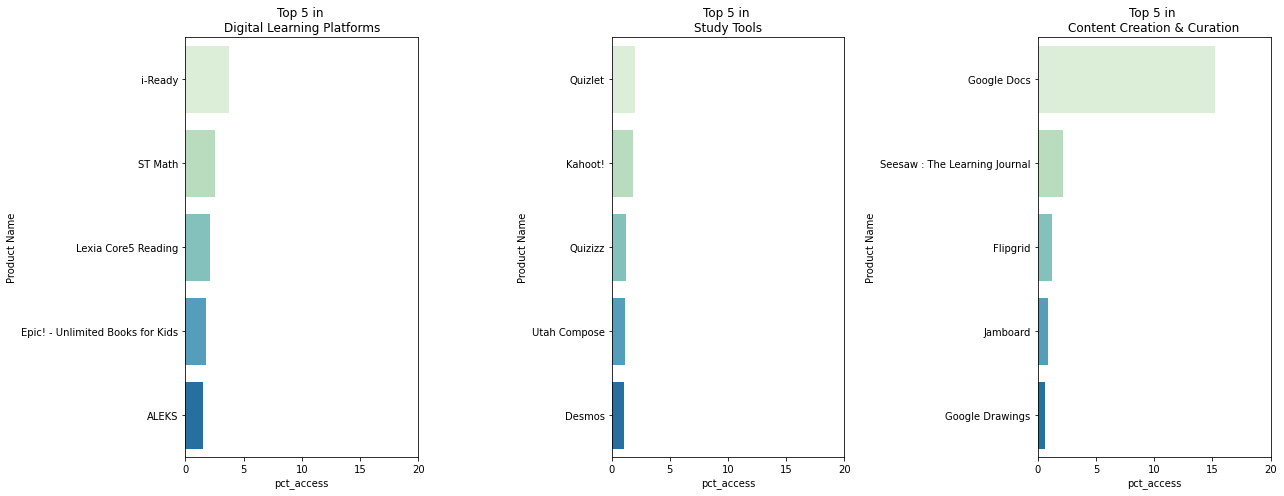

In [ ]:
#@title Top5 products for 'Digital Learning Platforms', 'Study Tools', 'Content Creation & Curation':

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 7))
i = 0 

subcategories = ['Digital Learning Platforms', 'Study Tools','Content Creation & Curation' ]

for subcat in subcategories:

  # Get the list of product ids from subcategory:
  lp_ids = products_df[products_df['primary_function']== subcat]['LP ID'].unique()

  # Extract engagement metrics from dataframe:
  temp_df = engagement_df[engagement_df.lp_id.isin(lp_ids)]
  temp_df = temp_df.groupby('lp_id').pct_access.mean().sort_values(ascending=False).to_frame().reset_index(drop=False)
  temp_df.rename(columns={'lp_id': 'LP ID'}, inplace=True)
  # Attach the product name to the ranking:
  temp_df = temp_df.merge(products_df[['LP ID', 'Product Name']], on='LP ID').head(5)

  # Plot the chart:
  sns.barplot(data=temp_df, x='pct_access', y='Product Name', palette='GnBu', ax=ax[i])
  ax[i].set_title(f'Top 5 in \n{subcat}', fontsize=12)
  ax[i].set_xlim([0, 20])
  i = i + 1

plt.tight_layout()
plt.show()

For `Digital Learning Platforms` we can find:
- **[i-Ready](https://www.curriculumassociates.com/)** which is set of solutions for distance learning used by 10M students in the U.S.
- **[ST Math](https://www.stmath.com/)** is a PreK-8 visual instructional math program created by MIND Research Institute.
- **[Lexia](https://www.lexialearning.com/)** is a comprehensive suite of learning solutions for Literacy.
- **[Epic!](https://www.getepic.com/)** is a digital reading platform recently acquired by Byju.
- **[ALEKS](https://www.aleks.com/)** which is a online learning program for Math, Chemistry, Statistics and more personalized for students so they can learn at their own pace.

As for `Study Tools`, we can find some of the well known names: [**Kahoot!**](https://kahoot.com/), [**Quizlet**](https://quizlet.com/zh-cn) both are game-based learning platforms. And [**Desmos**](https://www.desmos.com/?lang=zh-CN) which is a very useful tool for Maths learning and teaching.

Lastly, for `Content Creation & Curation` we can see **Google Docs** stands at the top with a very high pct_access value. Below that we find other useful tools like [**Seesaw**](https://web.seesaw.me/) which claims that it's used in over 200,000 classrooms and 1 out of 2 schools in the US and [**Flipgrid**](https://info.flipgrid.com/) which is a social learning platform. [**Jamboard**](https://edu.google.com/products/jamboard/) is a digital interactive whiteboard developed also by Google.

Overall it gives us a nice picture of the most common tools used by students and teachers. It is a little surprise that Khan Academy is not in the top5 in its category, as it is for Scratch.

In the end we have to remind ourselves that all this analysis is based exclusive on the data we have at the moment. A big chunk of the products information is missing as we have only 372 of the 8600 products. Nevertheless we can have this glimpse of these 372 digital learning products for the districts in our dataset.

## Q9: Which products have grown the most over the course of the pandemic in 2020?

For this purpose, we will average the `pct_access` and `engagement_index` data over each quarter in 2020 and then take the difference between the last quarter of 2020 and the first quarter of 2020.

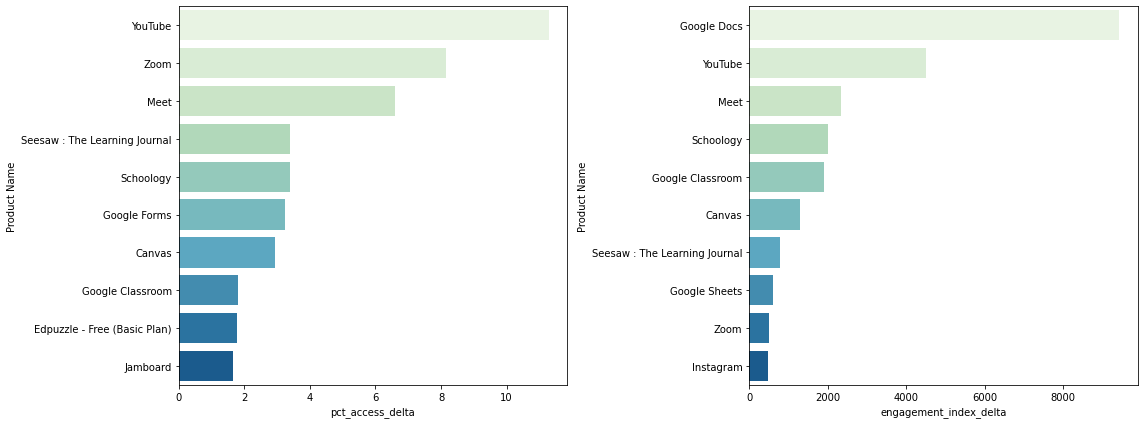

In [ ]:
#@title Top10 growth products:

# Create a 'quarter' column:
engagement_df['quarter'] = pd.DatetimeIndex(engagement_df['time']).quarter.astype(str)

# Create a df by grouping 'quarter' and 'lp_id':
temp_df = engagement_df.groupby(['quarter', 'lp_id'])['pct_access', 'engagement_index'].mean().reset_index(drop=False)
temp_df = temp_df.pivot(index='lp_id', columns='quarter')[['pct_access', 'engagement_index']].fillna(0)
temp_df.columns = ["_".join(a) for a in temp_df.columns.to_flat_index()]

# Create two new columns of delta
temp_df['pct_access_delta'] = temp_df['pct_access_4'] - temp_df['pct_access_1']
temp_df['engagement_index_delta'] = temp_df['engagement_index_4'] - temp_df['engagement_index_1']

# Append product names
products_df.rename(columns={'LP ID': 'lp_id'}, inplace=True)
temp_df = temp_df.merge(products_df[['lp_id', 'Product Name']], on='lp_id')

# Plot the chart:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

df = temp_df.sort_values(by='pct_access_delta', ascending=False).head(10)
sns.barplot(data=df, x='pct_access_delta', y='Product Name', palette='GnBu', ax=ax[0])

df = temp_df.sort_values(by='engagement_index_delta', ascending=False).head(10)
sns.barplot(data=df, x='engagement_index_delta', y='Product Name', palette='GnBu', ax=ax[1])

plt.tight_layout()
plt.show()

Analyzing the top10 growth chart we can see that:

- There is a good overlapping between the previous top10 products ranking and this top10 growth products. 
- **Google** as usual plays a very big role here occupying half of the top10 growth pct_access and 4 of the 10 positions on engagement_index.
- Virtual Classroom products (**Meet and Zoom**) are growting fast.
- **Schoology, Canvas and Seesaw** are the main top players besides Google.

## Final Thoughts:

Given the dataset by LearnPlatform we have analyzed the engagement metrics from two main point of view (from a geographic POV of school districts and States and from a products POV). In doing so we have tried to answer the four questions that are proposed at the beginning. 

Along with the insights, we have also unearthed a lot of new questions. Especially when we found out that some of the districts with very poor economic conditions performed drastically different (in that case much better) compared to other similar districts. Or in the same State we were finding a high number of the top districts along with one of the worst performers. These new questions will undoubtly lead us to new discoveries as we investigate further with additional data and talk with stakholders in specific districts.

This notebook **remains a working in progress** as we will approach the analysis from fresh new angles or try to answer new questions that will be raised in the future.






In [ ]:
%%shell
jupyter nbconvert --to html /content/“COVID_19_Impact_on_Digital_Learning_github_version_ipynb”.ipynb

[NbConvertApp] Converting notebook /content/“COVID_19_Impact_on_Digital_Learning_github_version_ipynb”.ipynb to html
[NbConvertApp] Writing 3383676 bytes to /content/“COVID_19_Impact_on_Digital_Learning_github_version_ipynb”.html
